In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-08-13 11:49:34 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-08-13 11:49:34 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-08-13 11:49:34 __main__ INFO     transformers.__version__='4.54.1'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-08-13 11:49:37 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-08-13 11:49:37 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-08-13 11:49:37 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-08-13 11:49:37 wandb.docker.auth DEBUG    No config file found


In [4]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-08-13 11:49:38 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory


2025-08-13 11:49:38 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443
2025-08-13 11:49:38 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-08-13 11:49:38 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2025-08-13 11:49:38 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/meta-llama/Llama-3.3-70B-Instruct/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-08-13 11:50:28 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-08-13 11:50:28 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-08-13 11:50:28 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [5]:
# file_path = os.path.join(
#     env_utils.DEFAULT_DATA_DIR,
#     "selection",
#     # "profession.json"
#     # "nationality.json"
#     "objects.json",
# )

# with open(file_path, "r") as f:
#     temp = json.load(f)

# for cat in temp["categories"]:
#     temp["categories"][cat] = [obj.capitalize() for obj in temp["categories"][cat]]

# with open(file_path, "w") as f:
#     json.dump(temp, f, indent=4)


In [6]:
from src.selection.data import SelectOneTask

select_prof = SelectOneTask.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        "profession.json"
        # "nationality.json"
        # "objects.json"
    )
)

print(select_prof)

SelectOneTask: (profession of a famous person)
Categories: actor(20), singer(20), comedian(20), director(20), basketball player(20), football player(20), soccer player(20), tennis player(20), golfer(20), boxer(20), news anchor(20), journalist(20), author(20), fashion designer(20), entrepreneur(19), politician(20)



In [7]:
sample = select_prof.get_random_sample(
    mt = mt,
    # prompt_template_idx=2,
    option_style="numbered",
    prompt_template_idx=0,
    # option_style="single_line",
    category="actor",
    # category="Brazil"
    # category="fruit",
    filter_by_lm_prediction=False,
)

print(sample)
print(sample.prompt())

Johnny Depp -> Leonardo DiCaprio (5): ['Adam Sandler', 'Diane von Furstenberg', 'Matt Fitzpatrick', 'Kara Swisher', 'Canelo Álvarez', 'Leonardo DiCaprio']
Which person from the following list share their profession with Johnny Depp?
a. Adam Sandler
b. Diane von Furstenberg
c. Matt Fitzpatrick
d. Kara Swisher
e. Canelo Álvarez
f. Leonardo DiCaprio
Answer:


In [8]:
from src.selection.utils import verify_correct_option
# sample.prompt_template = select_prof.prompt_templates[3]
print(f'"{sample.prompt()}"', ">>", sample.obj)

verify_correct_option(
    mt=mt,
    target=sample.obj,
    options=sample.options,
    input=sample.prompt()
)

"Which person from the following list share their profession with Johnny Depp?
a. Adam Sandler
b. Diane von Furstenberg
c. Matt Fitzpatrick
d. Kara Swisher
e. Canelo Álvarez
f. Leonardo DiCaprio
Answer:" >> Leonardo DiCaprio


(False,
 [PredictedToken(token=' f', prob=0.625, logit=21.0, token_id=282, metadata=None),
  PredictedToken(token=' a', prob=0.12353515625, logit=19.375, token_id=264, metadata=None),
  PredictedToken(token=' (', prob=0.06591796875, logit=18.75, token_id=320, metadata=None),
  PredictedToken(token=' Johnny', prob=0.058349609375, logit=18.625, token_id=32980, metadata=None),
  PredictedToken(token=' The', prob=0.04541015625, logit=18.375, token_id=578, metadata=None)],
 OrderedDict([(15387,
               (6,
                PredictedToken(token=' Adam', prob=0.01470947265625, logit=17.25, token_id=15387, metadata=None))),
              (66486,
               (10,
                PredictedToken(token=' Leonardo', prob=0.006134033203125, logit=16.375, token_id=66486, metadata=None))),
              (356,
               (36,
                PredictedToken(token=' C', prob=0.00017452239990234375, logit=12.8125, token_id=356, metadata=None))),
              (13678,
               (43,
     

In [12]:
print(sample.prompt(option_style="single_line"))

Options: Suit, Comb, Truck, Cow, Carnation, Yoga mat.
Which among these objects mentioned above is a flower?
Answer:


In [13]:
from src.functional import generate_with_patch

gen = generate_with_patch(
    mt = mt,
    inputs = sample.prompt(),
    max_new_tokens=20,
    do_sample=False,
    remove_prefix=True
)[0]
print(f'"{gen}"', ">>", sample.obj)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


" e. Carnation
Explanation: Carnation is a type of flower. It is a perennial plant" >> Carnation


In [108]:
# HEADS = [
#     (33, 45),
#     (33, 18),
#     (34, 1),
#     (34, 6),
#     (34, 7),
#     (35, 19),
#     (39, 40),
#     (42, 30),
#     (47, 18),
#     (52, 58),
# ]

with open("optimized_heads.json", "r") as f:
    HEADS = json.load(f)

# with open("category_wise_heads.json", "r") as f:
#     category_wise_heads = json.load(f)
# HEADS = [
#     (layer_idx, head_idx)
#     for layer_idx, head_idx, score in category_wise_heads["all"][:100]
# ]

print(len(HEADS))

HEADS = [(layer_idx, head_idx) for layer_idx, head_idx in HEADS if layer_idx < 61]
print(len(HEADS))

48
38


In [15]:
from src.attention import get_attention_matrices
from src.experiments.utils import (
    get_patches_to_verify_independent_enrichment,
    verify_head_patterns,
)

attn_pattern = verify_head_patterns(
    prompt = sample.prompt(),
    options = sample.options,
    pivot = sample.subj,
    mt = mt,
    heads = HEADS
)

0 patches to ablate possible answer information from options
2025-08-12 12:53:13 src.experiments.utils DEBUG    Predictions: ['" e"[384] (p=0.605, logit=21.875)', '" Carn"[32749] (p=0.173, logit=20.625)', '" ("[320] (p=0.135, logit=20.375)', '" The"[578] (p=0.030, logit=18.875)', '" Option"[7104] (p=0.018, logit=18.375)']
2025-08-12 12:53:13 src.experiments.utils INFO     Combined attention matrix for all heads


In [16]:
select_prof.category_wise_examples.keys()

dict_keys(['fruit', 'vehicle', 'furniture', 'animal', 'music instrument', 'clothing', 'electronics', 'sport equipment', 'kitchen appliance', 'vegetable', 'building', 'office supply', 'bathroom item', 'flower', 'tree', 'jewelry'])

In [57]:
import copy
import random
from src.selection.utils import KeyedSet, get_first_token_id, verify_correct_option
from src.selection.data import SelectionSample
from src.functional import predict_next_token
from src.tokens import prepare_input

######################################################################
N_DISTRACTORS = 5
WINDOW_SPEC = {
    mt.layer_name_format: 1,
    mt.mlp_module_name_format: 9,
    mt.attn_module_name_format: 9,
}
module_name_format = mt.layer_name_format
# module_name_format = mt.mlp_module_name_format
# module_name_format = mt.attn_module_name_format

######################################################################

@torch.inference_mode()
def get_counterfactual_samples_within_task(
    task: SelectOneTask = select_prof,
    patch_category: str | None = None,
    clean_category: str | None = None,
    shuffle_clean_options: bool = False,
    prompt_template_idx=2,
    option_style="numbered",
    filter_by_lm_prediction: bool = True,
    distinct_options: bool = False,
):
    categories = list(task.category_wise_examples.keys())
    if patch_category is None:
        patch_category = random.choice(categories)

    patch_subj, patch_obj = random.sample(
        task.category_wise_examples[patch_category], 2
    )
    logger.info(
        f"Patch category: {patch_category}, subject: {patch_subj}, object: {patch_obj}"
    )

    if clean_category is None:
        clean_category = random.choice(list(set(categories) - {patch_category}))

    clean_options = task.category_wise_examples[clean_category]
    random.shuffle(clean_options)

    clean_subj, clean_obj = random.sample(
        (KeyedSet(clean_options, mt.tokenizer) - KeyedSet([patch_obj], mt.tokenizer)).values, 2
    )
    logger.info(
        f"Clean category: {clean_category}, subject: {clean_subj}, object: {clean_obj}"
    )

    if distinct_options is False:
        patch_type_obj = patch_obj
        clean_type_obj = clean_obj
    else:
        patch_type_obj = random.choice(
            (KeyedSet(task.category_wise_examples[patch_category], mt.tokenizer) - KeyedSet([patch_obj], mt.tokenizer)).values
        )
        clean_type_obj = random.choice(
            (KeyedSet(task.category_wise_examples[clean_category], mt.tokenizer) - KeyedSet([clean_obj], mt.tokenizer)).values
        )

    patch_must_have_options = [patch_obj, clean_type_obj]
    clean_must_have_options = [clean_obj, patch_type_obj]

    logger.info(f"{patch_must_have_options=}")
    logger.info(f"{clean_must_have_options=}")
    logger.info(f"{clean_type_obj=}")
    logger.info(f"{patch_type_obj=}")

    patch_distractors = []
    other_categories = random.sample(
        list(set(categories) - {patch_category, clean_category}),
        k=N_DISTRACTORS - (len(patch_must_have_options)) + 1,
    )

    for other_category in other_categories:
        other_examples = task.category_wise_examples[other_category]
        random.shuffle(other_examples)
        other_examples = KeyedSet(other_examples, mt.tokenizer)
        patch_distractors.append(
            random.choice(
                (
                    other_examples
                    - KeyedSet(
                        patch_must_have_options + patch_distractors, tokenizer=mt.tokenizer
                    )
                ).values
            )
        )

    patch_options = patch_must_have_options + patch_distractors
    random.shuffle(patch_options)
    patch_obj_idx = patch_options.index(patch_obj)
    logger.info(f"{patch_obj_idx=} | {patch_options}")

    if distinct_options is not True:
        clean_options = copy.deepcopy(patch_options)
        if shuffle_clean_options:
            # Useful for the pointer experiments
            while (
                clean_options.index(clean_obj) == patch_obj_idx
                or clean_options.index(patch_obj) == patch_obj_idx
            ):
                random.shuffle(clean_options)
        clean_obj_idx = clean_options.index(clean_obj)

    else:
        other_categories = random.sample(
            list(set(categories) - {patch_category, clean_category}),
            k=N_DISTRACTORS - (len(clean_must_have_options)) + 1,
        )
        clean_distractors = []
        for other_category in other_categories:
            other_examples = task.category_wise_examples[other_category]
            random.shuffle(other_examples)
            other_examples = KeyedSet(other_examples, mt.tokenizer)
            clean_distractors.append(
                random.choice(
                    (
                        other_examples
                        - KeyedSet(
                            clean_must_have_options + clean_distractors, tokenizer=mt.tokenizer
                        )
                    ).values
                )
            )
        clean_options = clean_must_have_options + clean_distractors
        random.shuffle(clean_options)
        while clean_options.index(clean_obj) == patch_obj_idx:
            random.shuffle(clean_options)
        clean_obj_idx = clean_options.index(clean_obj)

    logger.info(f"{clean_obj_idx=} | {clean_options}")

    kwargs = dict(
        prompt_template= task.prompt_templates[prompt_template_idx],
        default_option_style=option_style,
    )
    patch_metadata = {
        "track_category": clean_category, 
        "track_type_obj": clean_type_obj,
        "track_type_obj_idx": patch_options.index(clean_type_obj),
        "track_type_obj_token_id": get_first_token_id(
            clean_type_obj, mt.tokenizer, prefix=" "
        ),
    }
    clean_metadata = {
        "track_category": patch_category,
        "track_type_obj": patch_type_obj,
        "track_type_obj_idx": clean_options.index(patch_type_obj),
        "track_type_obj_token_id": get_first_token_id(
            patch_type_obj, mt.tokenizer, prefix=" "
        ),
    }

    patch_sample = SelectionSample(
        subj=patch_subj,
        obj=patch_obj,
        answer=patch_obj,
        obj_idx=patch_obj_idx,
        ans_token_id=get_first_token_id(patch_obj, mt.tokenizer, prefix=" "),
        options=patch_options,
        category=patch_category,
        metadata = patch_metadata,
        **kwargs,
    )
    clean_sample = SelectionSample(
        subj=clean_subj,
        obj=clean_obj,
        answer=clean_obj,
        obj_idx=clean_obj_idx,
        ans_token_id=get_first_token_id(clean_obj, mt.tokenizer, prefix=" "),
        options=clean_options,
        category=clean_category,
        metadata = clean_metadata,
        **kwargs,
    )

    if filter_by_lm_prediction:
        test_samples = [patch_sample, clean_sample]
        if distinct_options is True:
            clean_sample_2 = copy.deepcopy(patch_sample)
            clean_sample_2.options = clean_options
            clean_sample_2.obj = clean_sample.metadata["track_type_obj"]
            clean_sample_2.obj_idx = clean_sample.metadata["track_type_obj_idx"]
            clean_sample_2.ans_token_id = clean_sample.metadata["track_type_obj_token_id"]
            test_samples.append(clean_sample_2)

        for sample in test_samples:
            tokenized = prepare_input(tokenizer=mt, prompts=sample.prompt())
            is_correct, predictions, track_options = verify_correct_option(
                mt=mt,
                target=sample.obj,
                options=sample.options,
                input=tokenized
            )
            sample.metadata["tokenized"] = tokenized.data
            logger.info(sample.prompt())
            logger.info(f"{sample.subj} | {sample.category} -> {sample.obj} | pred={[str(p) for p in predictions]}")
            if not is_correct:
                logger.error(
                    f'Prediction mismatch: {track_options[list(track_options.keys())[0]]}["{mt.tokenizer.decode(predictions[0].token_id)}"] != {sample.ans_token_id}["{mt.tokenizer.decode(sample.ans_token_id)}"]'
                )
                return get_counterfactual_samples_within_task(
                    task=task,
                    patch_category=patch_category,
                    clean_category=clean_category,
                    shuffle_clean_options=shuffle_clean_options,
                    prompt_template_idx=prompt_template_idx,
                    option_style=option_style,
                    filter_by_lm_prediction=filter_by_lm_prediction,
                )
            sample.prediction = predictions

    return patch_sample, clean_sample

In [58]:
patch_sample, clean_sample = get_counterfactual_samples_within_task(
    # patch_category="politician",
    # clean_category="actor",
    patch_category="fruit",
    clean_category="vehicle",
    filter_by_lm_prediction=True,
    prompt_template_idx=3,
    option_style="single_line",
    distinct_options=True,
)

clean_sample.metadata

2025-08-12 13:23:18 __main__ INFO     Patch category: fruit, subject: Strawberry, object: Watermelon
2025-08-12 13:23:18 __main__ INFO     Clean category: vehicle, subject: Airplane, object: Car
2025-08-12 13:23:18 __main__ INFO     patch_must_have_options=['Watermelon', 'Airplane']
2025-08-12 13:23:18 __main__ INFO     clean_must_have_options=['Car', 'Cherry']
2025-08-12 13:23:18 __main__ INFO     clean_type_obj='Airplane'
2025-08-12 13:23:18 __main__ INFO     patch_type_obj='Cherry'


2025-08-12 13:23:18 __main__ INFO     patch_obj_idx=4 | ['Drum', 'Scissors', 'Airplane', 'Boxing gloves', 'Watermelon', 'Projector']
2025-08-12 13:23:18 __main__ INFO     clean_obj_idx=2 | ['Cherry', 'Desk', 'Car', 'Refrigerator', 'Toothbrush', 'Ruler']
2025-08-12 13:23:19 __main__ INFO     Options: Drum, Scissors, Airplane, Boxing gloves, Watermelon, Projector.
Which among these objects mentioned above is a fruit?
Answer:
2025-08-12 13:23:19 __main__ INFO     Strawberry | fruit -> Watermelon | pred=['" Water"[10164] (p=0.828, logit=22.500)', '" The"[578] (p=0.087, logit=20.250)', '" Among"[22395] (p=0.041, logit=19.500)', '" A"[362] (p=0.017, logit=18.625)', '" water"[3090] (p=0.003, logit=17.000)']
2025-08-12 13:23:19 __main__ INFO     Options: Cherry, Desk, Car, Refrigerator, Toothbrush, Ruler.
Which among these objects mentioned above is a vehicle?
Answer:
2025-08-12 13:23:19 __main__ INFO     Airplane | vehicle -> Car | pred=['" Car"[3341] (p=0.699, logit=21.875)', '" The"[578] (p

{'track_category': 'fruit',
 'track_type_obj': 'Cherry',
 'track_type_obj_idx': 0,
 'track_type_obj_token_id': 45805,
 'tokenized': {'input_ids': tensor([[128000,   3883,     25,  45805,     11,  39794,     11,   3341,     11,
            75258,    859,     11,  83499,  37161,     11,    432,   8646,    627,
            23956,   4315,   1521,   6302,   9932,   3485,    374,    264,   7458,
             5380,  16533,     25]], device='cuda:0'),
  'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 1]], device='cuda:0')}}

In [108]:
patch_sample.metadata, clean_sample.metadata

({'track_category': 'actor',
  'track_type_obj': 'Leonardo DiCaprio',
  'track_type_obj_idx': 0,
  'track_type_obj_token_id': 66486},
 {'track_category': 'politician',
  'track_type_obj': 'Ted Cruz',
  'track_type_obj_idx': 4,
  'track_type_obj_token_id': 23989})

In [22]:
from src.functional import generate_with_patch

for sample in [patch_sample, clean_sample]:
    print(sample.prompt(), ">>", sample.obj)
    attn_pattern = verify_head_patterns(
        prompt=sample.prompt(),
        options=sample.options,
        pivot=sample.subj,
        mt=mt,
        heads=HEADS,
        generate_full_answer=True,
        query_index=-3
    )

Options: Eagle, Onion, Calculator, Spruce, House, Desk.
Which among these objects mentioned above is a building?
Answer: >> House
0 patches to ablate possible answer information from options
2025-08-11 10:37:05 src.experiments.utils DEBUG    Generated full answer: " House
Explanation: A house is a building or structure that serves as a dwelling or residence for one or more families or households. It is a physical"
2025-08-11 10:37:05 src.experiments.utils DEBUG    Predictions: ['" House"[4783] (p=0.855, logit=22.500)', '" The"[578] (p=0.043, logit=19.500)', '" A"[362] (p=0.043, logit=19.500)', '" Among"[22395] (p=0.026, logit=19.000)', '" It"[1102] (p=0.005, logit=17.375)']
2025-08-11 10:37:05 src.experiments.utils INFO     Combined attention matrix for all heads


Options: Daffodil, Pepper, Hospital, Dresser, Boxing gloves, Pencil.
Which among these objects mentioned above is a furniture?
Answer: >> Dresser
0 patches to ablate possible answer information from options
2025-08-11 10:37:09 src.experiments.utils DEBUG    Generated full answer: " Dresser
Explanation: A dresser is a piece of furniture that is used to store clothes, cosmetics, and other personal items. It is commonly found"
2025-08-11 10:37:09 src.experiments.utils DEBUG    Predictions: ['" Dress"[29318] (p=0.832, logit=22.375)', '" The"[578] (p=0.060, logit=19.750)', '" A"[362] (p=0.041, logit=19.375)', '" Among"[22395] (p=0.037, logit=19.250)', '" D"[423] (p=0.006, logit=17.500)']
2025-08-11 10:37:09 src.experiments.utils INFO     Combined attention matrix for all heads


## Testing patching the query projection of a single head

In [23]:
import baukit
from src.functional import get_module_nnsight, PatchSpec
from src.hooking.llama_attention import LlamaAttentionPatcher
import types
from typing import Literal
from src.tokens import prepare_input


def set_attn_implementation(mt, attn_implementation: Literal["sdpa", "eager"]):
    mt.config._attn_implementation = attn_implementation
    for layer_idx in range(mt.config.num_hidden_layers):
        attn_block_name = mt.attn_module_name_format.format(layer_idx)
        attn_block = baukit.get_module(mt._model, attn_block_name)
        attn_block.config._attn_implementation = attn_implementation


###################################################################################
batch_size = 1  # tokenized.input_ids.shape[0]
n_heads = mt.config.num_attention_heads
head_dim = mt.n_embd // n_heads
query_idx = -1 # almost always the last token
###################################################################################

mt.reset_forward()
set_attn_implementation(mt, "sdpa")

layer_idx, head_idx = HEADS[0]

attn_block_name = mt.attn_module_name_format.format(layer_idx)
attn_block = baukit.get_module(mt._model, attn_block_name)
attn_block.forward = types.MethodType(
    LlamaAttentionPatcher(block_name=attn_block_name),
    attn_block,
)

patch_tokenized = prepare_input(prompts=patch_sample.prompt(), tokenizer=mt)
patch_seq_len = patch_tokenized.input_ids.shape[1]
input_ln = mt.layer_name_format.format(layer_idx) + ".input_layernorm"

with mt.trace(patch_tokenized) as trace:
    ln_module = get_module_nnsight(mt, input_ln)
    patch_ln = ln_module.output.save()

    q_proj_name = mt.attn_module_name_format.format(layer_idx) + ".q_proj"
    q_proj_module = get_module_nnsight(mt, q_proj_name)
    patch_q_proj = q_proj_module.output.view(batch_size, patch_seq_len, n_heads, head_dim).transpose(1, 2).save()
    # patch_q_proj = PatchSpec(
    #     location=(q_proj_name + f".{head_idx}", -1),
    #     patch=patch_q_proj[:, head_idx, query_idx, :].squeeze().save()
    # )

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)
clean_seq_len = clean_tokenized.input_ids.shape[1]
with mt.trace(clean_tokenized) as trace:
    ln_module = get_module_nnsight(mt, input_ln)
    clean_ln = ln_module.output.save()

    q_proj_name = mt.attn_module_name_format.format(layer_idx) + ".q_proj"
    q_proj_module = get_module_nnsight(mt, q_proj_name)
    clean_q_proj = q_proj_module.output.view(batch_size, clean_seq_len, n_heads, head_dim).transpose(1, 2).save()
    # clean_q_proj = PatchSpec(
    #     location=(q_proj_name + f".{head_idx}", -1),
    #     patch=clean_q_proj[:, head_idx, query_idx, :].squeeze().save()
    # )

mt.reset_forward()
set_attn_implementation(mt, "eager")

patch_q_proj.shape, clean_q_proj.shape, patch_ln.shape, clean_ln.shape

2025-08-11 10:37:27 src.hooking.llama_attention DEBUG    LlamaAttentionPatcher <> model.layers.35.self_attn
2025-08-11 10:37:27 src.hooking.llama_attention DEBUG    hidden_shape=(1, 28, -1, 128) | input_shape=torch.Size([1, 28]) | torch.Size([1, 28, 8192])
2025-08-11 10:37:27 src.hooking.llama_attention DEBUG    query_states.size()=torch.Size([1, 64, 28, 128]) | key_states.size()=torch.Size([1, 8, 28, 128]) | value_states.size()=torch.Size([1, 8, 28, 128])
2025-08-11 10:37:27 src.hooking.llama_attention DEBUG    LlamaAttentionPatcher <> model.layers.35.self_attn
2025-08-11 10:37:27 src.hooking.llama_attention DEBUG    hidden_shape=(1, 33, -1, 128) | input_shape=torch.Size([1, 33]) | torch.Size([1, 33, 8192])
2025-08-11 10:37:27 src.hooking.llama_attention DEBUG    query_states.size()=torch.Size([1, 64, 33, 128]) | key_states.size()=torch.Size([1, 8, 33, 128]) | value_states.size()=torch.Size([1, 8, 33, 128])


(torch.Size([1, 64, 28, 128]),
 torch.Size([1, 64, 33, 128]),
 torch.Size([1, 28, 8192]),
 torch.Size([1, 33, 8192]))

In [27]:
from src.attention import visualize_attn_matrix
from src.functional import get_hs, interpret_logits

mt.reset_forward()
set_attn_implementation(mt, "sdpa")

layer_idx, head_idx = 35, 19

attn_matrices = {layer_idx: {}}

attn_block_name = mt.attn_module_name_format.format(layer_idx)
attn_block = baukit.get_module(mt._model, attn_block_name)
attn_block.forward = types.MethodType(
    LlamaAttentionPatcher(
        block_name=attn_block_name,
        save_attn_for=[head_idx],
        store_attn_matrices=attn_matrices[layer_idx],
    ),
    attn_block,
)

logit_location = (mt.lm_head_name, -1)
logits = get_hs(
    mt = mt,
    input = clean_tokenized,
    locations = [logit_location],
    return_dict=False
).squeeze()  # (seq_len, vocab_size)

mt.reset_forward()
set_attn_implementation(mt, "eager")

head_matrix = attn_matrices[layer_idx][head_idx].squeeze().to(torch.float32).cpu().numpy()

visualize_attn_matrix(
    attn_matrix=head_matrix,
    tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
    q_index=-1,
)

interpret_logits(
    tokenizer=mt,
    logits=logits,
    interested_tokens=[clean_sample.metadata["track_type_obj_token_id"]],
)

2025-08-11 10:38:24 src.hooking.llama_attention DEBUG    LlamaAttentionPatcher <> model.layers.35.self_attn
2025-08-11 10:38:24 src.hooking.llama_attention DEBUG    hidden_shape=(1, 33, -1, 128) | input_shape=torch.Size([1, 33]) | torch.Size([1, 33, 8192])
2025-08-11 10:38:24 src.hooking.llama_attention DEBUG    query_states.size()=torch.Size([1, 64, 33, 128]) | key_states.size()=torch.Size([1, 8, 33, 128]) | value_states.size()=torch.Size([1, 8, 33, 128])


([PredictedToken(token=' Dress', prob=0.83203125, logit=22.375, token_id=29318, metadata=None),
  PredictedToken(token=' The', prob=0.060302734375, logit=19.75, token_id=578, metadata=None),
  PredictedToken(token=' A', prob=0.04150390625, logit=19.375, token_id=362, metadata=None),
  PredictedToken(token=' Among', prob=0.03662109375, logit=19.25, token_id=22395, metadata=None),
  PredictedToken(token=' D', prob=0.00634765625, logit=17.5, token_id=423, metadata=None)],
 {15429: (38,
   PredictedToken(token=' Hospital', prob=0.0001163482666015625, logit=13.5, token_id=15429, metadata=None))})

In [28]:
clean_sample.metadata

{'track_category': 'building',
 'track_type_obj': 'Hospital',
 'track_type_obj_idx': 2,
 'track_type_obj_token_id': 15429}

In [29]:
from src.attention import visualize_attn_matrix

mt.reset_forward()
set_attn_implementation(mt, "sdpa")

layer_idx, head_idx = HEADS[0]

attn_matrices = {layer_idx: {}}

attn_block_name = mt.attn_module_name_format.format(layer_idx)
attn_block = baukit.get_module(mt._model, attn_block_name)
attn_block.forward = types.MethodType(
    LlamaAttentionPatcher(
        block_name=attn_block_name,
        save_attn_for=[head_idx],
        store_attn_matrices=attn_matrices[layer_idx],
        query_patches=[[head_idx, query_idx, patch_q_proj[:, head_idx, query_idx, :].squeeze()]],
    ),
    attn_block,
)

logit_location = (mt.lm_head_name, -1)
patch_logits = get_hs(
    mt = mt,
    input = clean_tokenized,
    locations = [logit_location],
    return_dict=False
).squeeze()  # (seq_len, vocab_size)

mt.reset_forward()
set_attn_implementation(mt, "eager")

head_matrix = attn_matrices[layer_idx][head_idx].squeeze().to(torch.float32).cpu().numpy()

visualize_attn_matrix(
    attn_matrix=head_matrix,
    tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
    q_index=-1,
)

interpret_logits(
    tokenizer=mt,
    logits=patch_logits,
    interested_tokens=[clean_sample.metadata["track_type_obj_token_id"]],
)

2025-08-11 10:38:26 src.hooking.llama_attention DEBUG    LlamaAttentionPatcher <> model.layers.35.self_attn
2025-08-11 10:38:26 src.hooking.llama_attention DEBUG    hidden_shape=(1, 33, -1, 128) | input_shape=torch.Size([1, 33]) | torch.Size([1, 33, 8192])
2025-08-11 10:38:26 src.hooking.llama_attention DEBUG    query_states.size()=torch.Size([1, 64, 33, 128]) | key_states.size()=torch.Size([1, 8, 33, 128]) | value_states.size()=torch.Size([1, 8, 33, 128])


([PredictedToken(token=' Dress', prob=0.8359375, logit=22.375, token_id=29318, metadata=None),
  PredictedToken(token=' The', prob=0.053466796875, logit=19.625, token_id=578, metadata=None),
  PredictedToken(token=' A', prob=0.041748046875, logit=19.375, token_id=362, metadata=None),
  PredictedToken(token=' Among', prob=0.036865234375, logit=19.25, token_id=22395, metadata=None),
  PredictedToken(token=' D', prob=0.004974365234375, logit=17.25, token_id=423, metadata=None)],
 {15429: (6,
   PredictedToken(token=' Hospital', prob=0.00341796875, logit=16.875, token_id=15429, metadata=None))})

In [30]:
# torch.allclose(patch_logits, logits, atol = 1e-3)

In [31]:
# torch.allclose(
#     patch_q_proj[:, head_idx, query_idx, :], 
#     clean_q_proj[:, head_idx, query_idx, :],
#     atol=1e-3
# )

In [32]:
# torch.allclose(
#     patch_ln[:, query_idx, :], 
#     clean_ln[:, query_idx, :],
#     atol=1e-3
# )

In [33]:
# patch_ln[:, query_idx, :], clean_ln[:, query_idx, :]

In [34]:
# # manual calculation
# attn_module = baukit.get_module(mt._model, mt.attn_module_name_format.format(layer_idx))
# patch_q_proj_manual = attn_module.q_proj(patch_ln)
# clean_q_proj_manual = attn_module.q_proj(clean_ln)

# print(patch_q_proj_manual.shape, clean_q_proj_manual.shape)
# print(torch.allclose(
#     patch_q_proj_manual[:, query_idx, :], 
#     clean_q_proj_manual[:, query_idx, :],
#     atol=1e-3
# ))

# patch_q_proj_manual = patch_q_proj_manual.reshape(batch_size, patch_seq_len, n_heads, head_dim).transpose(1, 2)
# clean_q_proj_manual = clean_q_proj_manual.reshape(batch_size, clean_seq_len, n_heads, head_dim).transpose(1, 2)
# print(patch_q_proj_manual.shape, clean_q_proj_manual.shape)

# for idx in range(n_heads):
#     print(head_idx, torch.allclose(
#         patch_q_proj_manual[:, idx, query_idx, :], 
#         clean_q_proj_manual[:, idx, query_idx, :],
#         atol=1e-3
#     ))

In [35]:
# torch.allclose(
#     patch_q_proj_manual[:, head_idx, query_idx, :], 
#     patch_q_proj[:, head_idx, query_idx, :],
#     atol=1e-3
# )

In [36]:
replace_q_proj = clean_q_proj.clone()
replace_q_proj[:, head_idx, query_idx, :] = patch_q_proj[:, head_idx, query_idx, :]

print(torch.allclose(
        replace_q_proj[:, head_idx, query_idx, :],
        clean_q_proj[:, head_idx, query_idx, :],
        atol=1e-3
    )
)
print(replace_q_proj.shape)

replace_q_proj = replace_q_proj.transpose(1, 2).reshape(batch_size, clean_seq_len, -1)

rep_patch = PatchSpec(
    location=(q_proj_name, -1),
    patch=replace_q_proj[:, -1, :].squeeze(),
)

ln_patch = PatchSpec(
    location=(input_ln, -1),
    patch=patch_ln[:, query_idx, :].squeeze(),
)

head_q_patch = PatchSpec(
    location=(q_proj_name, head_idx, -1),
    patch=patch_q_proj[:, head_idx, query_idx, :].squeeze(),
)

head_q_patch.location, rep_patch.location

False
torch.Size([1, 64, 33, 128])


(('model.layers.35.self_attn.q_proj', 19, -1),
 ('model.layers.35.self_attn.q_proj', -1))

In [37]:
# clean_q_proj_rs = clean_q_proj.view(batch_size, clean_seq_len, -1)
# patch_q_proj_rs = patch_q_proj.view(batch_size, clean_seq_len, -1)
# clean_q_proj_rs[:, -1, :].shape, patch_q_proj_rs[:, -1, :].shape

In [38]:
# torch.allclose(
#     replace_q_proj[:, -1, :].squeeze(), 
#     # patch_q_proj_rs[:, -1, :].squeeze(),
#     clean_q_proj_rs[:, -1, :].squeeze(), 
#     atol=1e-3
# )

In [39]:
patch_q_proj.shape, clean_q_proj.shape
# torch.allclose(patch_q_proj.patch, clean_q_proj.patch)

(torch.Size([1, 64, 28, 128]), torch.Size([1, 64, 33, 128]))

In [40]:
clean_sample.metadata

{'track_category': 'building',
 'track_type_obj': 'Hospital',
 'track_type_obj_idx': 2,
 'track_type_obj_token_id': 15429}

In [ ]:
from src.attention import get_attention_matrices, visualize_attn_matrix
from src.functional import interpret_logits

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)

attn_info = get_attention_matrices(
    input=clean_tokenized,
    mt=mt,
)

attn_matrix = attn_info.attention_matrices[layer_idx, head_idx].squeeze()
visualize_attn_matrix(
    attn_matrix=attn_matrix,
    tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
    q_index=-1,
)

interpret_logits(
    tokenizer=mt,
    logits=attn_info.logits,
    interested_tokens=[clean_sample.ans_token_id, clean_sample.metadata["track_type_obj_token_id"]]
)

([PredictedToken(token=' Dress', prob=0.83203125, logit=22.375, token_id=29318, metadata=None),
  PredictedToken(token=' The', prob=0.060302734375, logit=19.75, token_id=578, metadata=None),
  PredictedToken(token=' A', prob=0.041259765625, logit=19.375, token_id=362, metadata=None),
  PredictedToken(token=' Among', prob=0.03662109375, logit=19.25, token_id=22395, metadata=None),
  PredictedToken(token=' D', prob=0.00634765625, logit=17.5, token_id=423, metadata=None)],
 {29318: (1,
   PredictedToken(token=' Dress', prob=0.83203125, logit=22.375, token_id=29318, metadata=None)),
  15429: (38,
   PredictedToken(token=' Hospital', prob=0.0001163482666015625, logit=13.5, token_id=15429, metadata=None))})

In [ ]:
from src.attention import get_attention_matrices, visualize_attn_matrix
from src.functional import patch_with_nnsight, patch_with_baukit

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)

patched_attn_info = get_attention_matrices(
    input=clean_tokenized,
    mt=mt,
    # patches=[ln_patch],
    patches = [head_q_patch],
    # patches = [rep_patch],
    # patch_interface=patch_with_nnsight
    patch_interface=patch_with_baukit
)

patched_attn_matrix = patched_attn_info.attention_matrices[layer_idx, head_idx].squeeze()
visualize_attn_matrix(
    attn_matrix=patched_attn_matrix,
    tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
    q_index=-1,
)

interpret_logits(
    tokenizer=mt,
    logits=patched_attn_info.logits,
    interested_tokens=[clean_sample.ans_token_id, clean_sample.metadata["track_type_obj_token_id"]]
)

([PredictedToken(token=' Dress', prob=0.84765625, logit=22.375, token_id=29318, metadata=None),
  PredictedToken(token=' The', prob=0.0478515625, logit=19.5, token_id=578, metadata=None),
  PredictedToken(token=' A', prob=0.042236328125, logit=19.375, token_id=362, metadata=None),
  PredictedToken(token=' Among', prob=0.03271484375, logit=19.125, token_id=22395, metadata=None),
  PredictedToken(token=' D', prob=0.005035400390625, logit=17.25, token_id=423, metadata=None)],
 {29318: (1,
   PredictedToken(token=' Dress', prob=0.84765625, logit=22.375, token_id=29318, metadata=None)),
  15429: (6,
   PredictedToken(token=' Hospital', prob=0.0030517578125, logit=16.75, token_id=15429, metadata=None))})

## Patching a bunch of heads

### Loading the Heads

#### Attention Behavior

In [164]:
from dataclasses import dataclass
from dataclasses_json import DataClassJsonMixin
from src.utils.typing import ArrayLike, PathLike
import numpy as np
from src.attention import AttentionInformation

@dataclass
class SelectionSampleAttn(DataClassJsonMixin):
    sample: SelectionSample
    option_ranges: list[tuple[int, int]]
    attention_pattern: ArrayLike
    value_weighted_attention_pattern: ArrayLike | None = None

    def from_npz(file: np.lib.npyio.NpzFile | PathLike):
        if isinstance(file, PathLike):
            file = np.load(file, allow_pickle=True)

        sample = SelectionSample.from_dict(file["sample"].item())
        option_ranges = file["option_ranges"].tolist()
        attention_pattern = AttentionInformation.from_dict(
            file["attention_pattern"].item()
        )
        value_weighted_attention_pattern = (
            AttentionInformation.from_dict(
                file["value_weighted_attention_pattern"].item()
            )
            if "value_weighted_attention_pattern" in file
            else None
        )
        return SelectionSampleAttn(
            sample=sample,
            option_ranges=option_ranges,
            attention_pattern=attention_pattern,
            value_weighted_attention_pattern=value_weighted_attention_pattern,
        )

    def score_per_option(
        self,
        layer_idx: int,
        head_idx: int,
        query_idx: int = -1,
        value_weighted: bool = False,
        token_idx: Literal["last", "first", "all"] = "all",
    ):
        """Get the attention score for a specific layer and head."""
        attn_row = (
            self.attention_pattern.attention_matrices[layer_idx][head_idx][query_idx]
            if not value_weighted
            else self.value_weighted_attention_pattern.attention_matrices[layer_idx][
                head_idx
            ][query_idx]
        )
        attn_row = (
            torch.Tensor(attn_row)
            if not isinstance(attn_row, torch.Tensor)
            else attn_row
        )
        scores = []
        if token_idx == "all":
            option_ranges = self.option_ranges
        elif token_idx == "last":
            option_ranges = [(end - 1, end) for start, end in self.option_ranges]
        elif token_idx == "first":
            option_ranges = [(start, start + 1) for start, end in self.option_ranges]
        else:
            raise ValueError(
                f"Invalid token_idx: {token_idx}. Must be 'last', 'first', or 'all'."
            )
        for obj_range in option_ranges:
            start, end = obj_range
            scores.append(attn_row[start:end].sum().item())

        return scores

    def resolution_score(
        self,
        layer_idx: int,
        head_idx: int,
        query_idx: int = -1,
        value_weighted: bool = False,
        token_idx: Literal["last", "first", "all"] = "all",
    ):
        """See if the head prefers the answer over other options."""
        score_per_option = self.score_per_option(
            layer_idx=layer_idx,
            head_idx=head_idx,
            query_idx=query_idx,
            value_weighted=value_weighted,
            token_idx=token_idx,
        )
        answer_score = score_per_option[self.sample.obj_idx]
        other_scores = [
            score
            for i, score in enumerate(score_per_option)
            if i != self.sample.obj_idx
        ]
        diff = answer_score - max(other_scores)
        return diff, answer_score, other_scores

    def first_token_score(
        self,
        layer_idx: int,
        head_idx: int,
        query_idx: int = -1,
        value_weighted: bool = False,
    ):
        """Check if the head is looking only at the first token of the object."""
        attn_row = (
            self.attention_pattern.attention_matrices[layer_idx][head_idx][query_idx]
            if not value_weighted
            else self.value_weighted_attention_pattern.attention_matrices[layer_idx][
                head_idx
            ][query_idx]
        )
        attn_row = (
            torch.Tensor(attn_row)
            if not isinstance(attn_row, torch.Tensor)
            else attn_row
        )
        frm, to = self.option_ranges[self.sample.obj_idx]
        first_token_score = attn_row[frm].item()
        other_scores = attn_row[frm + 1 : to].sum().item()
        return first_token_score - other_scores, first_token_score, other_scores

In [165]:
attn_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/attention_patterns",
    mt.name.split("/")[-1]
)
files = sorted(os.listdir(attn_path))

#######################################################################
LIMIT = 100
# LIMIT = len(files)
#######################################################################

selection_attns = []

for npz_file in files[:LIMIT]:
    if not npz_file.endswith(".npz"):
        continue

    npz_path = os.path.join(attn_path, npz_file)
    selection_attns.append(SelectionSampleAttn.from_npz(npz_path))
    if len(selection_attns) % 10 == 0:
        print(f"Loaded {len(selection_attns)}/{LIMIT} files")

len(selection_attns)

Loaded 10/100 files
Loaded 20/100 files
Loaded 30/100 files
Loaded 40/100 files
Loaded 50/100 files
Loaded 60/100 files
Loaded 70/100 files
Loaded 80/100 files
Loaded 90/100 files
Loaded 100/100 files


100

In [166]:
from src.attention import visualize_attn_matrix

sample_idx = 18
# layer_idx = 39
# head_idx = 40
layer_idx = 54
head_idx = 44

selection_attn = selection_attns[sample_idx]
print(selection_attn.resolution_score(layer_idx, head_idx))
visualize_attn_matrix(
    attn_matrix=selection_attn.attention_pattern.attention_matrices[layer_idx, head_idx],
    tokens=selection_attn.attention_pattern.tokenized_prompt,
    q_index=-1,
    start_from=1,
)

(-2.1696090698242188e-05, 9.489059448242188e-05, [0.00011658668518066406, 6.937980651855469e-05, 0.00010991096496582031, 0.00010371208190917969, 9.202957153320312e-05])


In [167]:
from tqdm.auto import tqdm

#############################################################################
n_layer = mt.n_layer
n_head = mt.config.num_attention_heads
# token_idx = "all"
token_idx = "last"
##############################################################################

resolution_scores = torch.zeros((n_head, n_layer), dtype=torch.float32)
for selection_attn in tqdm(selection_attns):
    for layer_idx in range(n_layer):
        for head_idx in range(n_head):
            resolution_scores[head_idx, layer_idx] += selection_attn.resolution_score(
                layer_idx, head_idx, token_idx=token_idx
            )[0]
            # resolution_scores[head_idx, layer_idx] += selection_attn.first_token_score(
            #     layer_idx, head_idx
            # )[0]

resolution_scores /= len(selection_attns)
resolution_scores.shape

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([64, 80])

2025-08-11 15:19:33 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7faa7ef0b310>


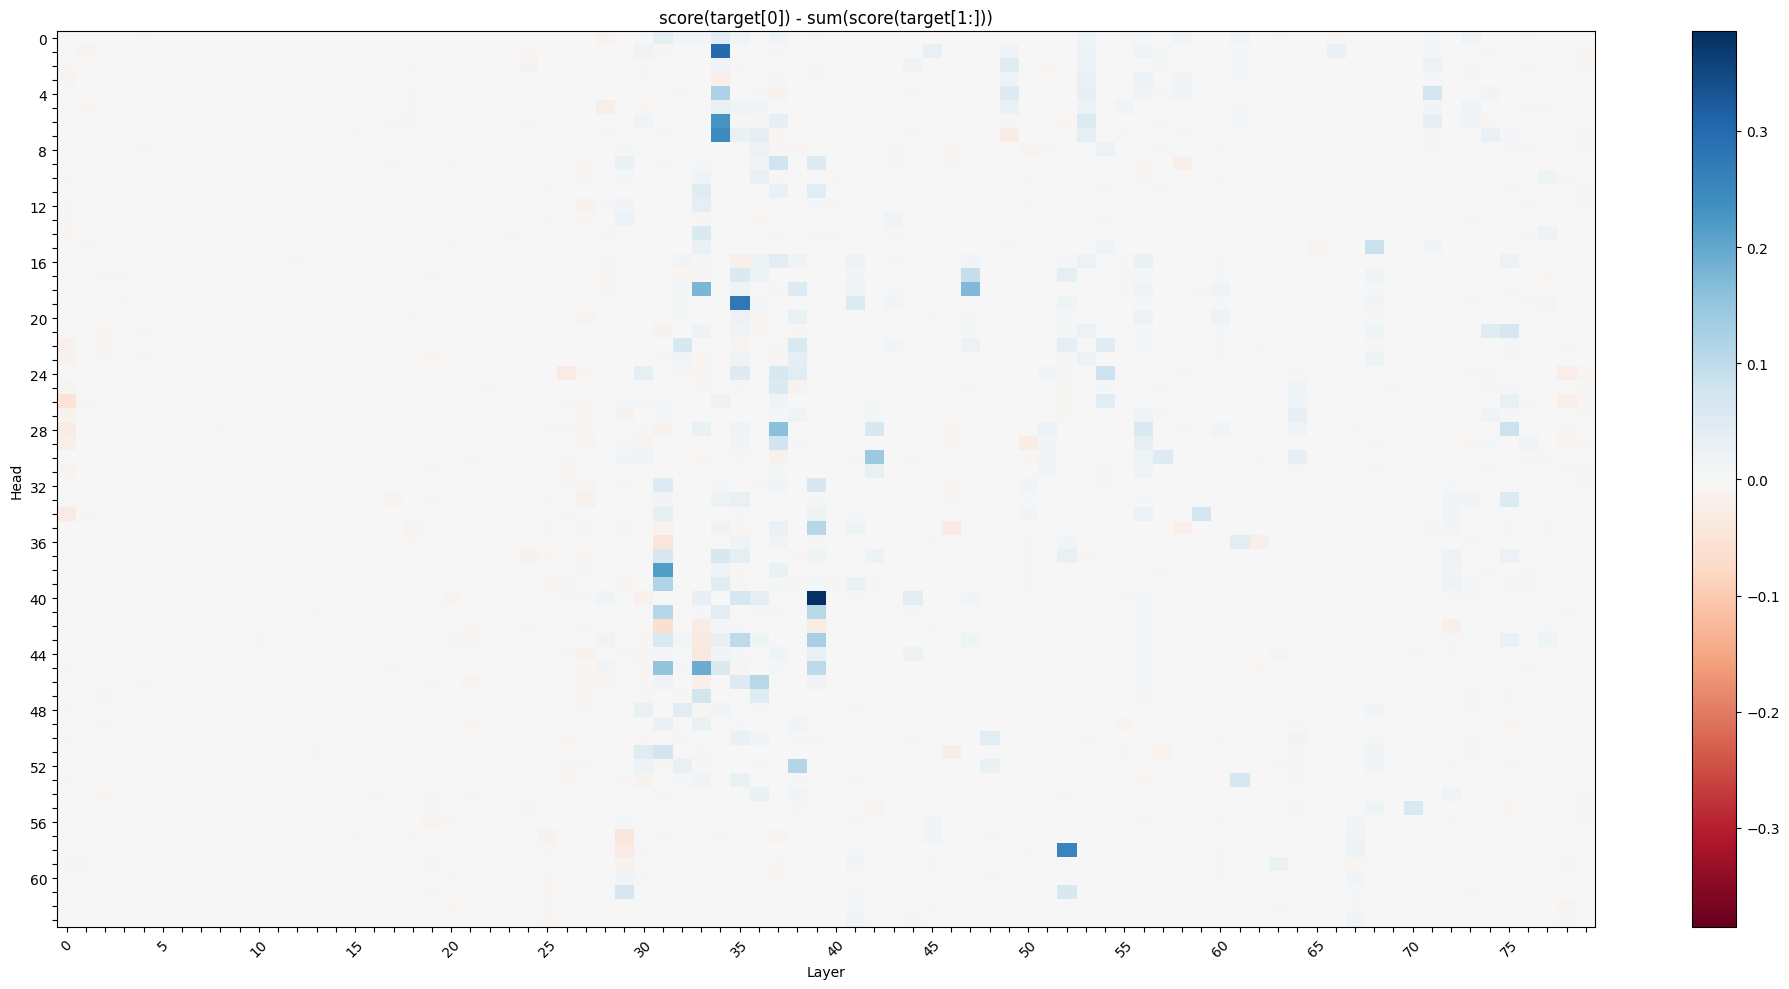

Layer 39, Head 40: 0.3857
Layer 34, Head 1: 0.3005
Layer 35, Head 19: 0.2758
Layer 52, Head 58: 0.2548
Layer 34, Head 7: 0.2447
Layer 34, Head 6: 0.2291
Layer 31, Head 38: 0.2148
Layer 33, Head 45: 0.1922
Layer 33, Head 18: 0.1749
Layer 47, Head 18: 0.1712
Layer 37, Head 28: 0.1607
Layer 31, Head 45: 0.1527
Layer 42, Head 30: 0.1432
Layer 39, Head 43: 0.1287
Layer 34, Head 4: 0.1216


In [169]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 10))
scale = torch.max(torch.abs(resolution_scores))
plt.imshow(
    resolution_scores.cpu().numpy(),
    cmap="RdBu",
    aspect="auto",
    vmin=-scale,
    vmax=scale,
)
plt.colorbar()
# plt.title(f"score(target) - max(score(distractors)) | {token_idx.upper()} tokens of options")
plt.title("score(target[0]) - sum(score(target[1:]))")
plt.xlabel("Layer")
plt.ylabel("Head")

def get_ticks(ticks, skip=5):
    ret = []
    for i in ticks:
        if i % skip == 0:
            ret.append(str(i))
        else:
            ret.append("")
    return ret

plt.xticks(
    ticks=range(n_layer),
    labels=get_ticks(range(n_layer)),
    rotation=45,
)
plt.yticks(
    ticks=range(n_head),
    labels=get_ticks(range(n_head), skip=4),
)

plt.tight_layout()
plt.show()


scores_per_head = []
for head_idx in range(n_head):
    for layer_idx in range(n_layer):
        scores_per_head.append(
            (head_idx, layer_idx, resolution_scores[head_idx, layer_idx].item())
        )

scores_per_head = sorted(scores_per_head, key=lambda x: x[2], reverse=True)
for head_idx, layer_idx, score in scores_per_head[:15]:
    print(f"Layer {layer_idx}, Head {head_idx}: {score:.4f}")

In [177]:
HEADS = [(layer_idx, head_idx) for head_idx, layer_idx, score in scores_per_head[:100]]
print(HEADS)

[(39, 40), (34, 1), (35, 19), (52, 58), (34, 7), (34, 6), (31, 38), (33, 45), (33, 18), (47, 18), (37, 28), (31, 45), (42, 30), (39, 43), (34, 4), (31, 39), (38, 52), (31, 41), (39, 35), (39, 41), (36, 46), (39, 45), (35, 43), (47, 17), (68, 15), (75, 28), (54, 24), (37, 29), (37, 9), (59, 34), (71, 4), (31, 51), (33, 47), (35, 40), (61, 53), (75, 21), (29, 61), (32, 22), (31, 37), (39, 32), (52, 61), (34, 37), (42, 28), (70, 55), (37, 24), (38, 22), (56, 28), (31, 43), (37, 25), (34, 45), (35, 17), (33, 14), (75, 33), (41, 19), (53, 6), (35, 46), (38, 18), (35, 24), (57, 30), (31, 32), (39, 9), (49, 4), (74, 21), (30, 51), (49, 2), (54, 22), (36, 47), (33, 11), (32, 48), (34, 0), (48, 50), (61, 36), (38, 24), (34, 41), (34, 39), (44, 40), (54, 26), (37, 16), (39, 11), (56, 29), (31, 0), (36, 40), (31, 34), (52, 17), (30, 24), (35, 37), (38, 23), (52, 22), (53, 7), (33, 12), (36, 7), (71, 6), (53, 4), (64, 27), (33, 40), (64, 30), (37, 6), (34, 43), (30, 48), (32, 52)]


#### Based on Patching Score

In [87]:
from scripts.patching_within_task import SelectionQprojPatchResult
from tqdm.auto import tqdm


q_proj_root = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/q_states_patching",
    mt.name.split("/")[-1],
)

#############################################
# LIMIT = 10
LIMIT = None
n_layer = mt.n_layer
n_head = mt.config.num_attention_heads
categories = [
    "profession",
    "nationality",
    "objects",
]
#############################################

q_proj_results = {cat: [] for cat in categories}

for category in categories:
    print(f"category: {category}")
    q_proj_path = os.path.join(q_proj_root, category)
    files = sorted(os.listdir(q_proj_path))
    LIMIT = LIMIT or len(files)
    q_proj_results[category] = []
    for file in tqdm(files[:LIMIT]):
        if not file.endswith(".json"):
            continue

        file_path = os.path.join(q_proj_path, file)
        q_proj_results[category].append(SelectionQprojPatchResult.load_from_json(file_path))
        # if len(q_proj_results) % 10 == 0:
        #     print(f"Loaded {len(q_proj_results)}/{LIMIT} files")



category: profession


  0%|          | 0/150 [00:00<?, ?it/s]

category: nationality


  0%|          | 0/150 [00:00<?, ?it/s]

category: objects


  0%|          | 0/150 [00:00<?, ?it/s]

In [88]:
combine_all_results = []
for category in categories:
    combine_all_results.extend(q_proj_results[category])

results_copy = copy.deepcopy(q_proj_results)
results_copy["all"] = combine_all_results

In [89]:
len(results_copy["profession"])

150

2025-08-11 09:32:36 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7ee8e35d08d0>
2025-08-11 09:32:36 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2025-08-11 09:32:36 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-08-11 09:32:36 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2025-08-11 09:32:36 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/disk/

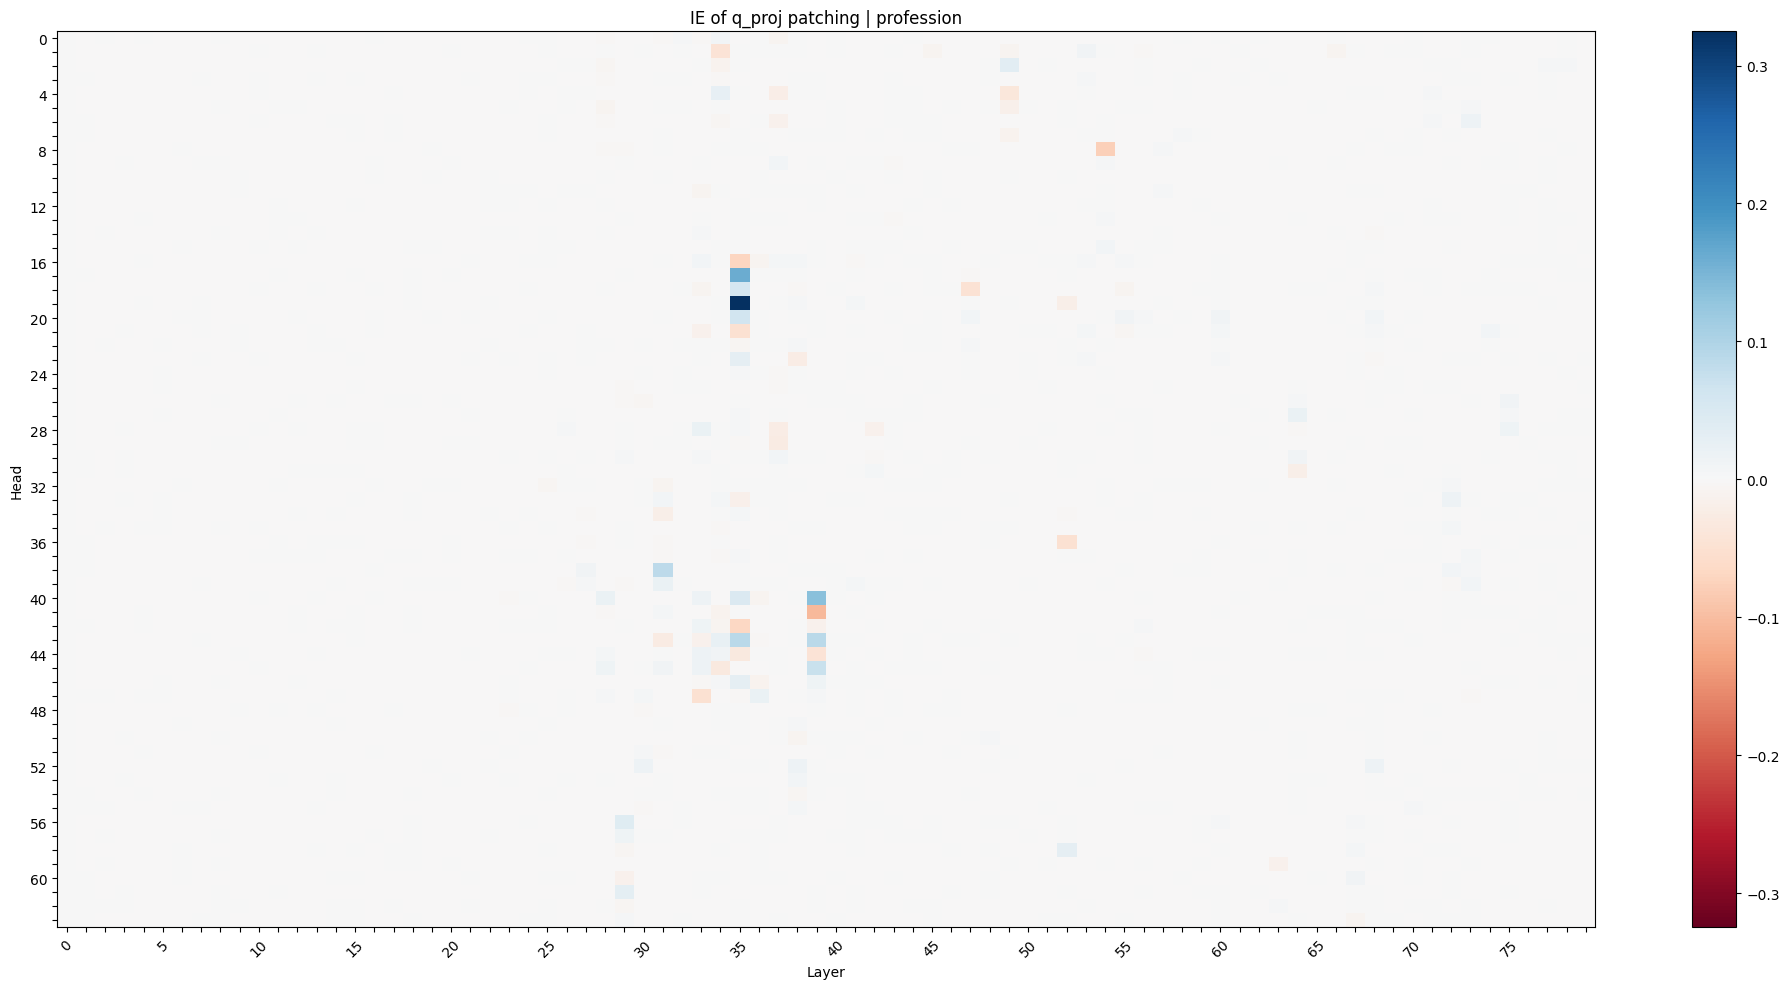

Layer 35, Head 19: 0.3248
Layer 35, Head 17: 0.1599
Layer 39, Head 40: 0.1348
Layer 39, Head 43: 0.0881
Layer 35, Head 43: 0.0880
Layer 31, Head 38: 0.0852
Layer 39, Head 45: 0.0720
Layer 35, Head 20: 0.0617
Layer 35, Head 18: 0.0551
Layer 35, Head 40: 0.0461
Layer 29, Head 56: 0.0398
Layer 49, Head 2: 0.0334
Layer 29, Head 61: 0.0324
Layer 52, Head 58: 0.0303
Layer 35, Head 23: 0.0298
2025-08-11 09:32:39 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7ee8e4868250>


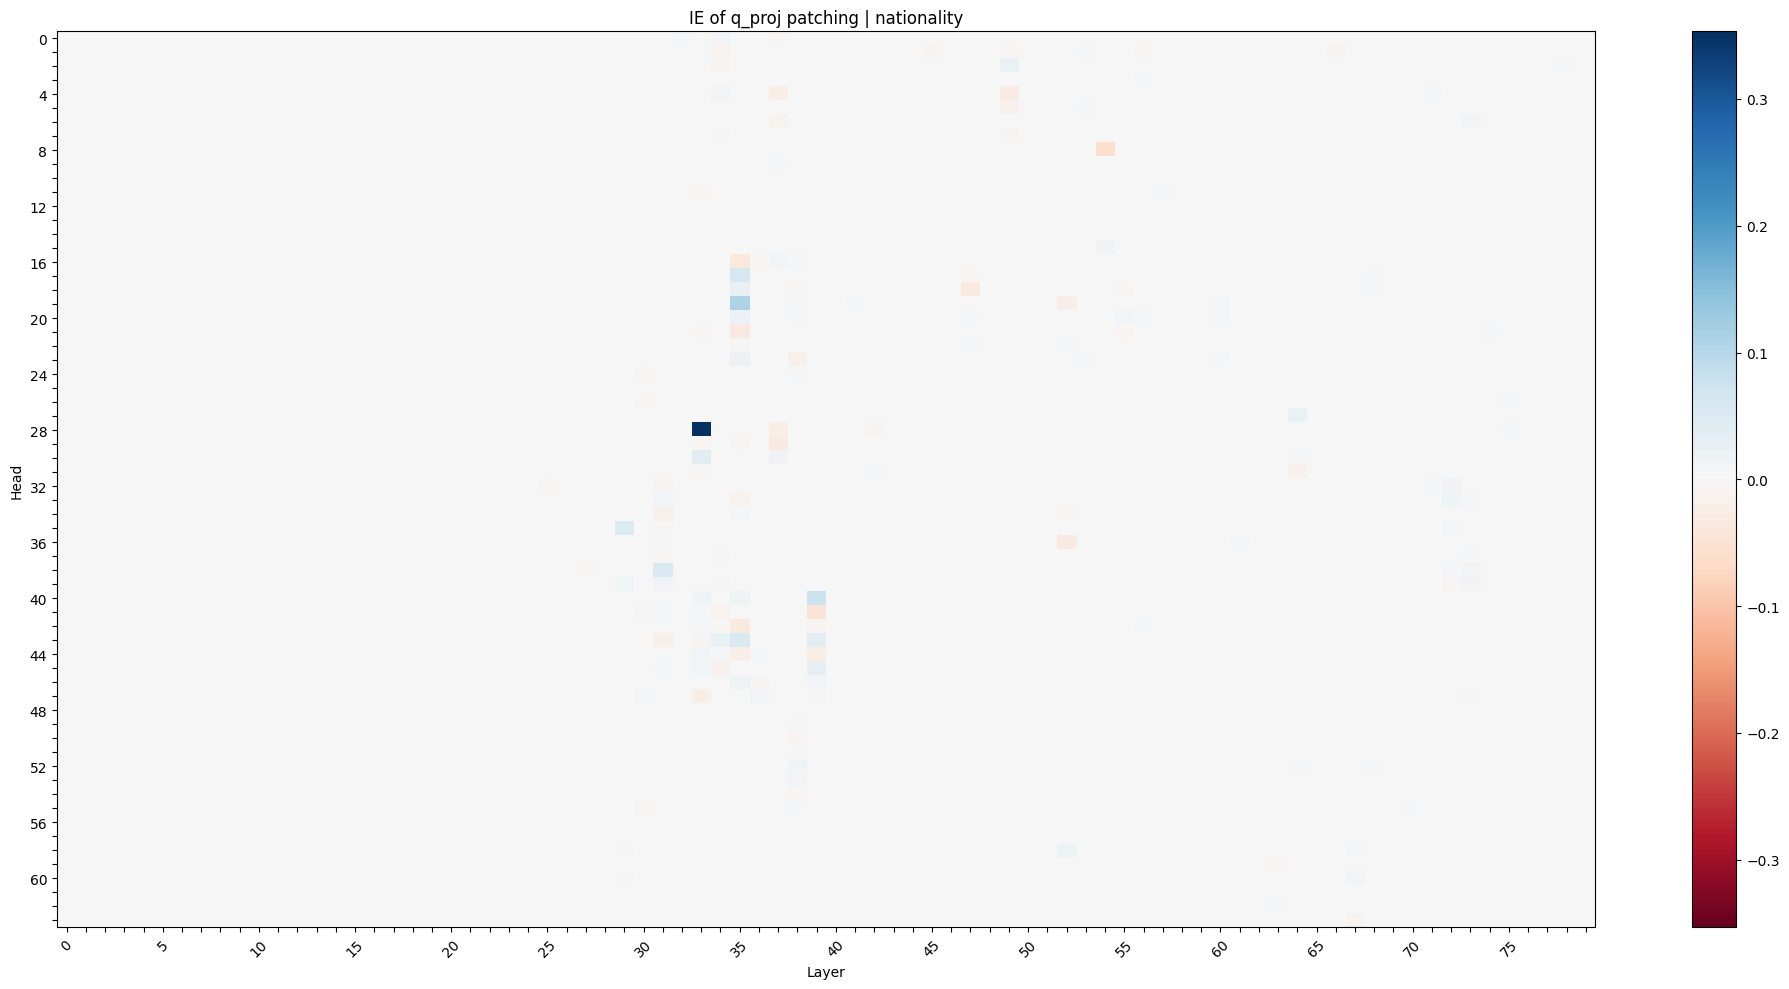

Layer 33, Head 28: 0.3533
Layer 35, Head 19: 0.1081
Layer 39, Head 40: 0.0748
Layer 35, Head 17: 0.0591
Layer 31, Head 38: 0.0549
Layer 35, Head 43: 0.0528
Layer 29, Head 35: 0.0495
Layer 39, Head 43: 0.0403
Layer 33, Head 30: 0.0362
Layer 39, Head 45: 0.0306
Layer 35, Head 18: 0.0274
Layer 34, Head 43: 0.0253
Layer 49, Head 2: 0.0233
Layer 64, Head 27: 0.0224
Layer 35, Head 20: 0.0211
2025-08-11 09:32:41 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7ee8f1d976d0>


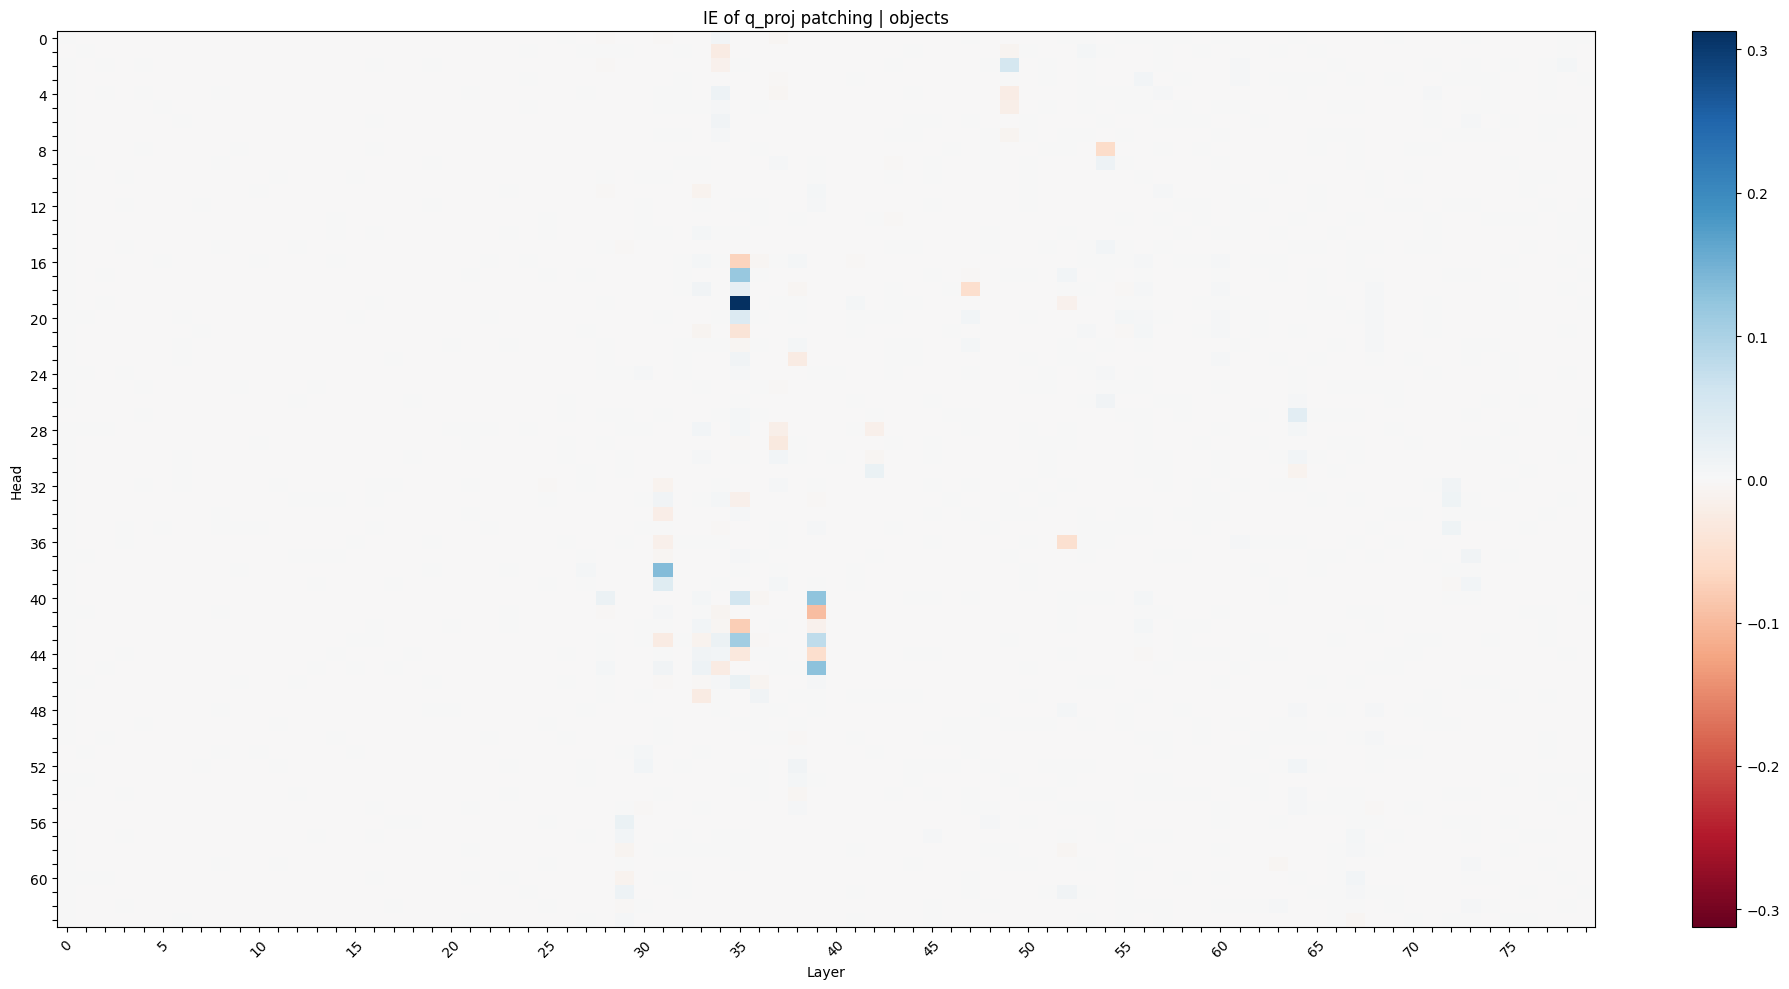

Layer 35, Head 19: 0.3127
Layer 31, Head 38: 0.1344
Layer 39, Head 45: 0.1280
Layer 39, Head 40: 0.1267
Layer 35, Head 17: 0.1187
Layer 35, Head 43: 0.1093
Layer 39, Head 43: 0.0782
Layer 35, Head 40: 0.0585
Layer 49, Head 2: 0.0557
Layer 35, Head 20: 0.0431
Layer 31, Head 39: 0.0375
Layer 64, Head 27: 0.0333
Layer 35, Head 18: 0.0262
Layer 29, Head 56: 0.0206
Layer 42, Head 31: 0.0205
2025-08-11 09:32:48 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7ee8f2f10150>


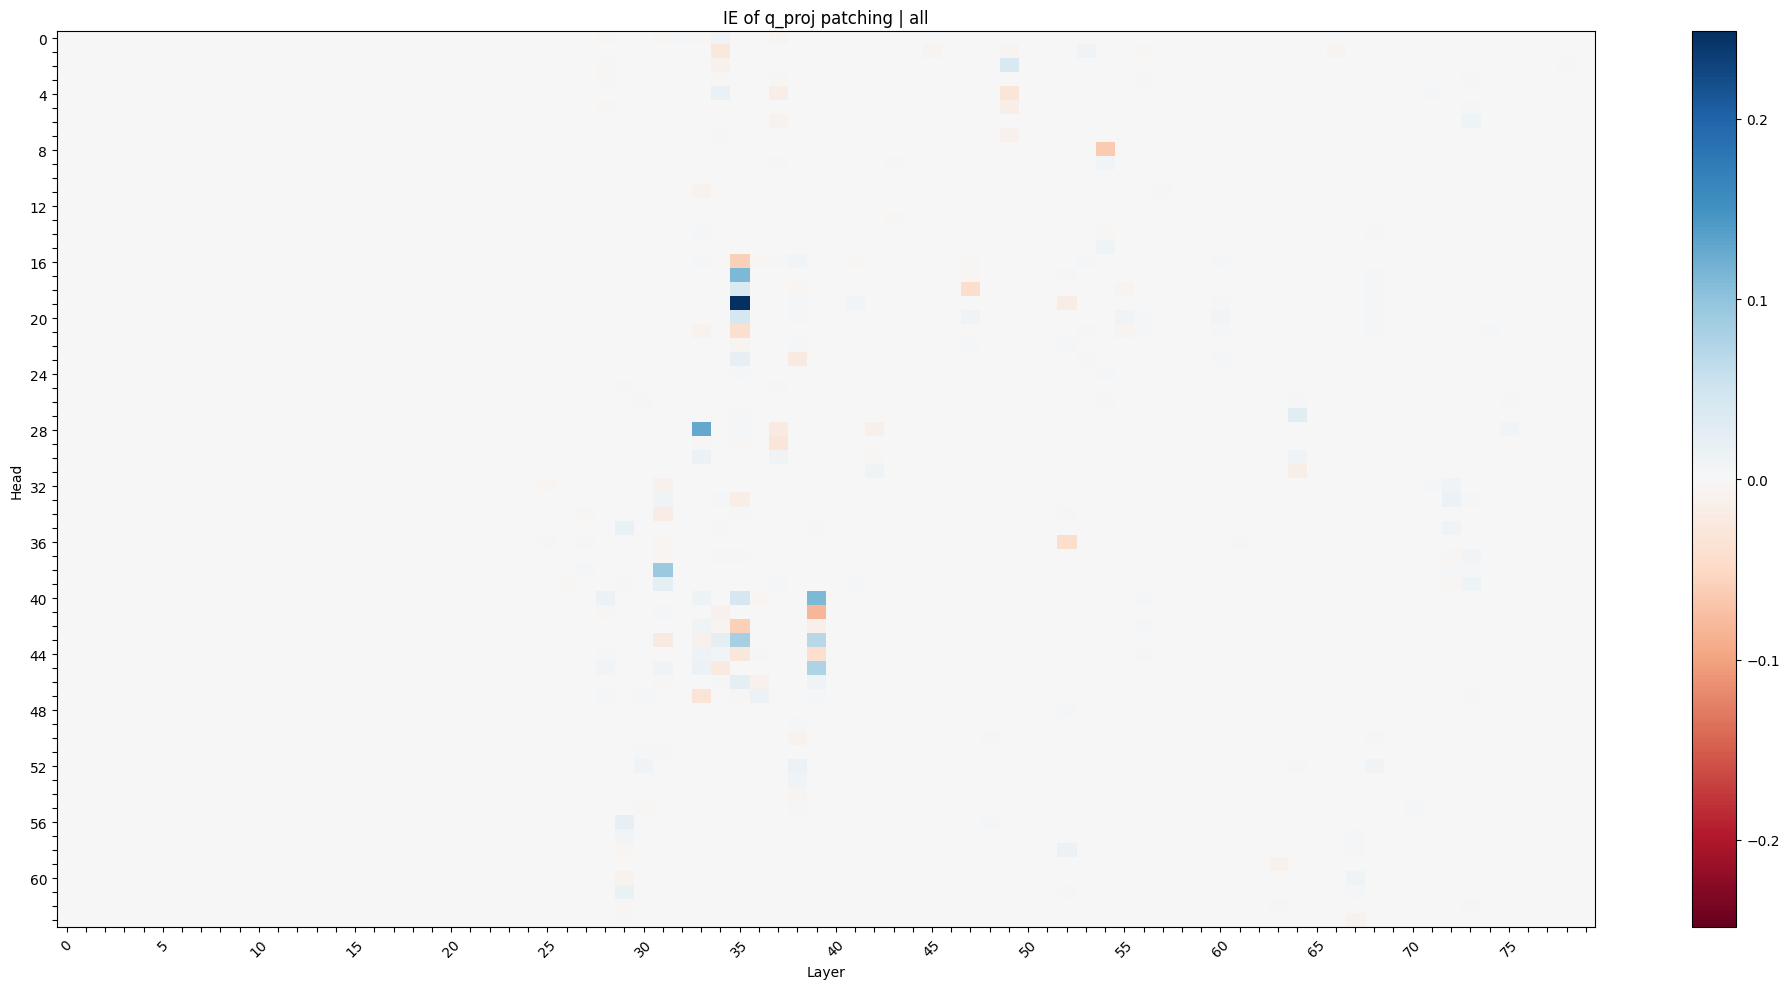

Layer 35, Head 19: 0.2485
Layer 33, Head 28: 0.1277
Layer 35, Head 17: 0.1126
Layer 39, Head 40: 0.1121
Layer 31, Head 38: 0.0915
Layer 35, Head 43: 0.0834
Layer 39, Head 45: 0.0769
Layer 39, Head 43: 0.0689
Layer 35, Head 20: 0.0420
Layer 35, Head 40: 0.0412
Layer 49, Head 2: 0.0375
Layer 35, Head 18: 0.0362
Layer 64, Head 27: 0.0256
Layer 31, Head 39: 0.0239
Layer 35, Head 46: 0.0223


In [90]:
from matplotlib import pyplot as plt

category_wise_heads = {}
for category, categorywise_result in results_copy.items():
    indirect_effects = torch.zeros((n_layer, n_heads), dtype=torch.float32)
    for layer_idx in range(mt.n_layer):
        for head_idx in range(mt.config.num_attention_heads):
            indirect_effects[layer_idx, head_idx] = torch.mean(
                torch.tensor(
                    [
                        sample_result.head_effect(layer_idx, head_idx)
                        for sample_result in categorywise_result
                    ]
                )
            )

    plt.figure(figsize=(20, 10))
    scale = torch.max(torch.abs(indirect_effects))
    plt.imshow(
        indirect_effects.T.cpu().numpy(),
        cmap="RdBu",
        aspect="auto",
        vmin=-scale,
        vmax=scale,
    )
    plt.colorbar()
    # plt.title(f"score(target) - max(score(distractors)) | {token_idx.upper()} tokens of options")
    plt.title("IE of q_proj patching | " + category)
    plt.xlabel("Layer")
    plt.ylabel("Head")

    def get_ticks(ticks, skip=5):
        ret = []
        for i in ticks:
            if i % skip == 0:
                ret.append(str(i))
            else:
                ret.append("")
        return ret

    plt.xticks(
        ticks=range(n_layer),
        labels=get_ticks(range(n_layer)),
        rotation=45,
    )
    plt.yticks(
        ticks=range(n_head),
        labels=get_ticks(range(n_head), skip=4),
    )

    plt.tight_layout()
    plt.show()


    scores_per_head = []
    for layer_idx in range(n_layer):
        for head_idx in range(n_head):
            scores_per_head.append(
                (layer_idx, head_idx, indirect_effects[layer_idx, head_idx].item())
            )

    scores_per_head = sorted(scores_per_head, key=lambda x: x[2], reverse=True)
    category_wise_heads[category] = scores_per_head
    for layer_idx, head_idx, score in scores_per_head[:15]:
        print(f"Layer {layer_idx}, Head {head_idx}: {score:.4f}")

with open("category_wise_heads.json", "w") as f:
    json.dump(category_wise_heads, f, indent=4)

#### Performing the Patch

In [29]:
from src.tokens import prepare_input
from src.functional import get_module_nnsight

# HEADS = [
#     (33, 45),
#     (33, 18),
#     (34, 1),
#     (34, 6),
#     (34, 7),
#     (35, 19),
#     (39, 40),
#     (42, 30),
#     (47, 18),
#     (52, 58),
# ]

# HEADS = [
#     (layer_idx, head_idx)
#     for layer_idx, head_idx, score in category_wise_heads["all"][:50]
# ]

# HEADS = heads_selected

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)
patch_tokenized = prepare_input(prompts=patch_sample.prompt(), tokenizer=mt)

# category_wise_heads["all"][len(HEADS) - 1]

In [36]:
from src.utils.typing import TokenizerOutput


@torch.inference_mode()
def cache_q_projections(
    mt: ModelandTokenizer,
    input: TokenizerOutput,
    query_locations: list[tuple[int, int, int]],  # (layer_idx, head_idx, query_idx)
    return_output: bool = False,
):
    layer_to_hq = {}
    for layer_idx, head_idx, query_idx in query_locations:
        if layer_idx not in layer_to_hq:
            layer_to_hq[layer_idx] = []
        layer_to_hq[layer_idx].append((head_idx, query_idx))

    q_projections = {}
    batch_size = input.input_ids.shape[0]
    seq_len = input.input_ids.shape[1]
    n_heads = mt.config.num_attention_heads
    head_dim = mt.n_embd // n_heads
    with mt.trace(input) as tracer:
        for layer_idx, query_locs in layer_to_hq.items():
            q_proj_name = mt.attn_module_name_format.format(layer_idx) + ".q_proj"
            q_proj_module = get_module_nnsight(mt, q_proj_name)
            q_proj_out = q_proj_module.output.view(
                batch_size, seq_len, n_heads, head_dim
            ).transpose(1, 2)
            for head_idx, query_idx in query_locs:
                q_projections[(layer_idx, head_idx, query_idx)] = (
                    q_proj_out[:, head_idx, query_idx, :].squeeze().save()
                )

        if return_output:
            output = mt.output.save()

    if return_output:
        return q_projections, output
    return q_projections

In [37]:
list(range(-3, 0))

[-3, -2, -1]

In [38]:
query_indices = list(range(-3, 0))
query_locations = [
    (layer_idx, head_idx, query_idx)
    for layer_idx, head_idx in HEADS
    for query_idx in query_indices
]

cached_q_states = cache_q_projections(
    mt=mt,
    input=patch_tokenized,
    query_locations=query_locations,
    # heads=[(35, 19)],
    # heads=patching_heads,
)

# cached_q_states[(HEADS[0])].shape

In [39]:
from src.attention import get_attention_matrices, visualize_attn_matrix
from src.functional import interpret_logits

clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)

# attn_info = get_attention_matrices(
#     input=clean_tokenized,
#     mt=mt,
# )

# layer_idx, head_idx = 35, 19
# attn_matrix = attn_info.attention_matrices[layer_idx, head_idx].squeeze()
# visualize_attn_matrix(
#     attn_matrix=attn_matrix,
#     tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
#     q_index=-1,
# )

# interpret_logits(
#     tokenizer=mt,
#     logits=attn_info.logits,
#     interested_tokens=[clean_sample.obj_token_id, clean_sample.metadata["track_type_obj_token_id"]]
# )

attn_pattern = verify_head_patterns(
    prompt = clean_tokenized,
    options = clean_sample.options,
    pivot = clean_sample.subj,
    mt = mt,
    heads = HEADS,
    # heads = patching_heads,
    generate_full_answer=True,
)

attn_pattern["predictions"]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-12 13:08:32 src.experiments.utils DEBUG    Generated full answer: " Helicopter.
Explanation: A helicopter is a type of aircraft that is used for transportation, rescue operations, and other purposes. It is a vehicle that"
2025-08-12 13:08:32 src.experiments.utils DEBUG    Predictions: ['" Hel"[16183] (p=0.828, logit=22.000)', '" The"[578] (p=0.060, logit=19.375)', '" A"[362] (p=0.047, logit=19.125)', '" Among"[22395] (p=0.028, logit=18.625)', '" It"[1102] (p=0.004, logit=16.625)']
2025-08-12 13:08:32 src.experiments.utils INFO     Combined attention matrix for all heads


[PredictedToken(token=' Hel', prob=0.828125, logit=22.0, token_id=16183, metadata=None),
 PredictedToken(token=' The', prob=0.06005859375, logit=19.375, token_id=578, metadata=None),
 PredictedToken(token=' A', prob=0.046875, logit=19.125, token_id=362, metadata=None),
 PredictedToken(token=' Among', prob=0.0284423828125, logit=18.625, token_id=22395, metadata=None),
 PredictedToken(token=' It', prob=0.00384521484375, logit=16.625, token_id=1102, metadata=None)]

In [40]:
from src.attention import get_attention_matrices, visualize_attn_matrix
from src.functional import patch_with_nnsight, patch_with_baukit, PatchSpec

q_proj_patches = []
for (layer_idx, head_idx, query_idx), q_proj in cached_q_states.items():
    q_proj_patches.append(
        PatchSpec(
            location=(mt.attn_module_name_format.format(layer_idx) + ".q_proj", head_idx, query_idx),
            patch=q_proj
        )
    )

# patched_attn_info = get_attention_matrices(
#     input=clean_tokenized,
#     mt=mt,
#     patches=q_proj_patches,
#     patch_interface=patch_with_baukit
# )

# layer_idx, head_idx = 35, 19
# patched_attn_matrix = patched_attn_info.attention_matrices[layer_idx, head_idx].squeeze()
# visualize_attn_matrix(
#     attn_matrix=patched_attn_matrix,
#     tokens=[mt.tokenizer.decode(t) for t in clean_tokenized.input_ids[0]],
#     q_index=-1,
# )

# interpret_logits(
#     tokenizer=mt,
#     logits=patched_attn_info.logits,
#     interested_tokens=[clean_sample.obj_token_id, clean_sample.metadata["track_type_obj_token_id"]]
# )

patched_attn_pattern = verify_head_patterns(
    prompt = clean_tokenized,
    options = clean_sample.options,
    pivot = clean_sample.subj,
    mt = mt,
    heads = HEADS,
    # heads = patching_heads,
    query_patches=q_proj_patches,
    # generate_full_answer=True,
)

patched_attn_pattern["predictions"]

144 patches to ablate possible answer information from options
2025-08-12 13:08:36 src.experiments.utils DEBUG    Predictions: ['" Peach"[64695] (p=0.926, logit=22.625)', '" The"[578] (p=0.022, logit=18.875)', '" Among"[22395] (p=0.015, logit=18.500)', '" Tul"[43316] (p=0.008, logit=17.875)', '" A"[362] (p=0.006, logit=17.625)']
2025-08-12 13:08:36 src.experiments.utils INFO     Combined attention matrix for all heads


[PredictedToken(token=' Peach', prob=0.92578125, logit=22.625, token_id=64695, metadata=None),
 PredictedToken(token=' The', prob=0.021728515625, logit=18.875, token_id=578, metadata=None),
 PredictedToken(token=' Among', prob=0.01495361328125, logit=18.5, token_id=22395, metadata=None),
 PredictedToken(token=' Tul', prob=0.00799560546875, logit=17.875, token_id=43316, metadata=None),
 PredictedToken(token=' A', prob=0.0062255859375, logit=17.625, token_id=362, metadata=None)]

### Search over layers and heads

In [48]:
clean_sample.metadata

{'track_category': 'building',
 'track_type_obj': 'Hospital',
 'track_type_obj_idx': 2,
 'track_type_obj_token_id': 15429}

In [49]:
from scripts.patching_within_task import SelectionQprojPatchResult

In [ ]:
from itertools import product
from src.functional import patch_with_baukit, interpret_logits

interested_tokens = [
    patch_sample.ans_token_id,
    clean_sample.ans_token_id,
    clean_sample.metadata["track_type_obj_token_id"]
]
all_heads = list(product(range(20, 60), range(mt.config.num_attention_heads)))
all_q_projections, patch_out = cache_q_projections(
    mt=mt,
    input=patch_tokenized,
    heads=all_heads,
    query_idx=-1,
    return_output=True
)
logger.debug(len(all_q_projections))

patch_logits = patch_out.logits[:, -1, :].squeeze()
patch_precitions, patch_track = interpret_logits(
    tokenizer=mt,
    logits=patch_logits,
    interested_tokens=interested_tokens,
)

patch_precitions, patch_track

2025-08-11 10:40:18 __main__ DEBUG    2560


([PredictedToken(token=' House', prob=0.85546875, logit=22.5, token_id=4783, metadata=None),
  PredictedToken(token=' The', prob=0.042724609375, logit=19.5, token_id=578, metadata=None),
  PredictedToken(token=' A', prob=0.042724609375, logit=19.5, token_id=362, metadata=None),
  PredictedToken(token=' Among', prob=0.02587890625, logit=19.0, token_id=22395, metadata=None),
  PredictedToken(token=' It', prob=0.005096435546875, logit=17.375, token_id=1102, metadata=None)],
 {4783: (1,
   PredictedToken(token=' House', prob=0.85546875, logit=22.5, token_id=4783, metadata=None)),
  15429: (517,
   PredictedToken(token=' Hospital', prob=6.295740604400635e-07, logit=8.375, token_id=15429, metadata=None)),
  29318: (1873,
   PredictedToken(token=' Dress', prob=9.639188647270203e-08, logit=6.5, token_id=29318, metadata=None))})

In [51]:
clean_out = patch_with_baukit(
    mt=mt,
    inputs=clean_tokenized,
    patches=[],
)

base_logits = clean_out.logits[:, -1, :].squeeze()
base_predictions, base_track = interpret_logits(
    tokenizer=mt,
    logits=base_logits,
    interested_tokens=interested_tokens,
)
base_predictions, base_track

([PredictedToken(token=' Dress', prob=0.83203125, logit=22.375, token_id=29318, metadata=None),
  PredictedToken(token=' The', prob=0.060302734375, logit=19.75, token_id=578, metadata=None),
  PredictedToken(token=' A', prob=0.041259765625, logit=19.375, token_id=362, metadata=None),
  PredictedToken(token=' Among', prob=0.03662109375, logit=19.25, token_id=22395, metadata=None),
  PredictedToken(token=' D', prob=0.00634765625, logit=17.5, token_id=423, metadata=None)],
 {29318: (1,
   PredictedToken(token=' Dress', prob=0.83203125, logit=22.375, token_id=29318, metadata=None)),
  15429: (38,
   PredictedToken(token=' Hospital', prob=0.0001163482666015625, logit=13.5, token_id=15429, metadata=None)),
  4783: (452,
   PredictedToken(token=' House', prob=7.338821887969971e-07, logit=8.4375, token_id=4783, metadata=None))})

In [52]:
int_out = patch_with_baukit(
    mt = mt,
    inputs = clean_tokenized,
    patches = q_proj_patches,
)

logits = int_out.logits[:, -1, :].squeeze()

interpret_logits(
    tokenizer=mt,
    logits=logits,
    interested_tokens=interested_tokens
)

([PredictedToken(token=' Hospital', prob=0.796875, logit=21.625, token_id=15429, metadata=None),
  PredictedToken(token=' Among', prob=0.057861328125, logit=19.0, token_id=22395, metadata=None),
  PredictedToken(token=' The', prob=0.044921875, logit=18.75, token_id=578, metadata=None),
  PredictedToken(token=' A', prob=0.02734375, logit=18.25, token_id=362, metadata=None),
  PredictedToken(token=' Dress', prob=0.018798828125, logit=17.875, token_id=29318, metadata=None)],
 {15429: (1,
   PredictedToken(token=' Hospital', prob=0.796875, logit=21.625, token_id=15429, metadata=None)),
  29318: (5,
   PredictedToken(token=' Dress', prob=0.018798828125, logit=17.875, token_id=29318, metadata=None)),
  4783: (343,
   PredictedToken(token=' House', prob=2.4586915969848633e-06, logit=8.9375, token_id=4783, metadata=None))})

In [ ]:
head_wise_patching_effects = {}

for (layer_idx, head_idx), q_proj in tqdm(all_q_projections.items()):
    q_proj_patch = PatchSpec(
        location=(mt.attn_module_name_format.format(layer_idx) + ".q_proj", head_idx, -1),
        patch=q_proj
    )
    out = patch_with_baukit(
        mt = mt,
        inputs = clean_tokenized,
        patches = [q_proj_patch],
    )
    logits = out.logits[:, -1, :].squeeze()
    predictions, track = interpret_logits(
        tokenizer=mt,
        logits=logits,
        interested_tokens=interested_tokens
    )
    head_wise_patching_effects[(layer_idx, head_idx)] = track

  0%|          | 0/2560 [00:00<?, ?it/s]

Patched Layer 21, Head 35: [PredictedToken(token=' Will', prob=0.5625, logit=20.25, token_id=4946, metadata=None), PredictedToken(token=' (', prob=0.09765625, logit=18.5, token_id=320, metadata=None), PredictedToken(token=' Option', prob=0.076171875, logit=18.25, token_id=7104, metadata=None), PredictedToken(token=' ', prob=0.076171875, logit=18.25, token_id=220, metadata=None), PredictedToken(token=' The', prob=0.046142578125, logit=17.75, token_id=578, metadata=None)] | {4946: (1, PredictedToken(token=' Will', prob=0.5625, logit=20.25, token_id=4946, metadata=None)), 35336: (33, PredictedToken(token=' Nancy', prob=0.000659942626953125, logit=13.5, token_id=35336, metadata=None)), 11519: (639, PredictedToken(token=' Mike', prob=2.5331974029541016e-06, logit=7.9375, token_id=11519, metadata=None))}
Patched Layer 23, Head 7: [PredictedToken(token=' Will', prob=0.55859375, logit=20.25, token_id=4946, metadata=None), PredictedToken(token=' (', prob=0.09716796875, logit=18.5, token_id=320,

In [ ]:
patching_results = SelectionQprojPatchResult(
    patch_sample=patch_sample,
    clean_sample=clean_sample,
    interested_tokens=interested_tokens,
    base_results=base_track,
    gold_results=patch_track,
    headwise_patching_effects=head_wise_patching_effects
)

NameError: name 'head_wise_patching_effects' is not defined

In [ ]:
patching_results.head_effect(layer_idx=35, head_idx=19)

0.4214876033057851

In [ ]:
headwise_scores = [
    (
        layer_idx,
        head_idx,
        patching_results.head_effect(layer_idx, head_idx)
    )
    for layer_idx, head_idx in head_wise_patching_effects.keys()
]

headwise_scores = sorted(headwise_scores, key=lambda x: x[2], reverse=True)
patching_heads = []
for layer_idx, head_idx, score in headwise_scores[:15]:
    print(f"Layer {layer_idx}, Head {head_idx}: {score:.4f}")
    patching_heads.append((layer_idx, head_idx))

Layer 35, Head 19: 0.4215
Layer 39, Head 45: 0.2645
Layer 39, Head 43: 0.2397
Layer 31, Head 38: 0.1983
Layer 35, Head 20: 0.1818
Layer 35, Head 23: 0.0992
Layer 35, Head 43: 0.0992
Layer 35, Head 17: 0.0826
Layer 49, Head 2: 0.0744
Layer 31, Head 33: 0.0661
Layer 37, Head 30: 0.0661
Layer 35, Head 18: 0.0579
Layer 30, Head 52: 0.0496
Layer 31, Head 39: 0.0496
Layer 33, Head 47: 0.0496


In [ ]:
patching_results.delist_patching_effects()
with open("patching_results.json", "w") as f:
    json.dump(patching_results.to_dict(), f, indent=4)

In [ ]:
with open("patching_results.json", "r") as f:
    loaded_results = json.load(f)

loaded_results["headwise_patching_effects"] = {
    (int(layer_idx.split("_<>_")[0]), int(layer_idx.split("_<>_")[1])): effect
    for layer_idx, effect in loaded_results["headwise_patching_effects"].items()
}

In [ ]:
loaded_results["headwise_patching_effects"].keys()

In [ ]:
patching_results_loaded = SelectionQprojPatchResult.from_dict(loaded_results)
patching_results_loaded.head_effect(layer_idx=35, head_idx=19)

0.4214876033057851

In [ ]:
mt.config.num_attention_heads

64

## Optimization to select heads to patch

In [129]:
from torch.optim import AdamW
from torch.utils.data import DataLoader
from src.utils.typing import TokenizerOutput
from src.functional import free_gpu_cache
import baukit


def get_optimal_head_mask(
    mt: ModelandTokenizer,
    train_set: list[tuple[SelectionSample, SelectionSample]],
    learning_rate: float = 1e-3,
    n_epochs: int = 5,
    lamb: float = 1e-3,
    batch_size: int = 4,
    query_indices: int = [-1],
):
    hparams = {
        "learning_rate": learning_rate,
        "n_epochs": n_epochs,
        "lamb": lamb,
        "batch_size": batch_size,
    }
    logger.debug(f"Training with hparams: {hparams}")
    n_layer = mt.n_layer
    n_heads = mt.config.num_attention_heads

    mask = torch.ones(
        (n_layer, n_heads), dtype=mt.dtype, requires_grad=True, device=mt.device
    )

    # prompts = []
    # prompts.extend([sample.prompt() for sample in clean_samples])
    # prompts.extend([sample.prompt() for sample in patch_samples])
    # tokenized = prepare_input(prompts=prompts, tokenizer=mt)

    # clean_tokenized = TokenizerOutput(data = {k: v[:len(clean_samples), :] for k, v in tokenized.items()})
    # patch_tokenized = TokenizerOutput(data = {k: v[len(clean_samples):, :] for k, v in tokenized.items()})

    optimizer = AdamW([mask], lr=learning_rate)
    losses = []

    all_heads = [
        (layer_idx, head_idx)
        for layer_idx in range(n_layer)
        for head_idx in range(n_heads)
    ]
    all_q_proj_modules = [
        mt.attn_module_name_format.format(layer_idx) + ".q_proj"
        for layer_idx in range(n_layer)
    ]
    batches = []
    for batch_start in range(0, len(train_set), batch_size):
        batches.append(train_set[batch_start : batch_start + batch_size])

    query_locations = [
        (layer_idx, head_idx, query_idx)
        for layer_idx, head_idx in all_heads
        for query_idx in query_indices
    ]

    logger.info("Caching q projections from patch samples...")
    q_projections_from_patch_samples = {}
    for batch_idx, batch in enumerate(batches):
        clean_samples, patch_samples = zip(*batch)
        prompts = []
        prompts.extend([sample.prompt() for sample in clean_samples])
        prompts.extend([sample.prompt() for sample in patch_samples])
        tokenized = prepare_input(prompts=prompts, tokenizer=mt)
        # clean_tokenized = TokenizerOutput(data = {k: v[:len(clean_samples), :] for k, v in tokenized.items()})
        patch_tokenized = TokenizerOutput(
            data={k: v[len(clean_samples) :, :] for k, v in tokenized.items()}
        )

        q_projections = cache_q_projections(
            mt=mt,
            input=patch_tokenized,
            query_locations=query_locations,
            return_output=False,
        )

        patches = {}
        for (layer_idx, head_idx, query_idx), q_proj in q_projections.items():
            module_name = mt.attn_module_name_format.format(layer_idx) + ".q_proj"
            patches[(module_name, head_idx)] = (layer_idx, q_proj)
        q_projections_from_patch_samples[batch_idx] = patches
        logger.info(f"Caching completed > {batch_idx+1}/{len(batches)} batches.")
        free_gpu_cache()

    logger.info("Starting training...")

    for epoch in range(n_epochs):
        epoch_loss = 0
        for batch_idx, batch in enumerate(batches):
            optimizer.zero_grad()

            batch_size_actual = len(batch)

            clean_samples, patch_samples = zip(*batch)
            prompts = []
            prompts.extend([sample.prompt() for sample in clean_samples])
            prompts.extend([sample.prompt() for sample in patch_samples])
            tokenized = prepare_input(prompts=prompts, tokenizer=mt)
            clean_tokenized = TokenizerOutput(
                data={k: v[: len(clean_samples), :] for k, v in tokenized.items()}
            )
            patch_tokenized = TokenizerOutput(
                data={k: v[len(clean_samples) :, :] for k, v in tokenized.items()}
            )
            batch_target_tokens = [
                clean_sample.metadata["track_type_obj_token_id"]
                for clean_sample in clean_samples
            ]
            batch_distractor_tokens = [
                [
                    get_first_token_id(tokenizer=mt.tokenizer, name=option, prefix=" ")
                    for idx, option in enumerate(clean_sample.options)
                    if idx != clean_sample.metadata["track_type_obj_idx"]
                ]
                for clean_sample in clean_samples
            ]

            patch_q_states = q_projections_from_patch_samples[batch_idx]

            batch_size = clean_tokenized.input_ids.shape[0]
            seq_len = clean_tokenized.input_ids.shape[1]
            head_dim = mt.n_embd // n_heads

            def perform_patch(repr, layer_name):
                if layer_name not in all_q_proj_modules:
                    return repr

                repr = repr.view(batch_size, seq_len, n_heads, head_dim).transpose(1, 2)
                for head_idx in range(n_heads):
                    q_clean = repr[:, head_idx, query_idx, :]
                    layer_idx, q_patch = patch_q_states[(layer_name, head_idx)]
                    q_patch = q_patch.clone().to(q_clean.dtype).to(q_clean.device)
                    q_patch.requires_grad = True
                    coeff = (
                        mask[layer_idx, head_idx].to(q_clean.dtype).to(q_clean.device)
                    )
                    # head_patch = coeff * q_patch + (1 - coeff) * q_clean
                    repr[:, head_idx, query_idx, :] += coeff * (q_patch - q_clean)

                repr = repr.transpose(1, 2).view(
                    batch_size, seq_len, n_heads * head_dim
                )
                return repr

            with baukit.TraceDict(
                module=mt._model, layers=all_q_proj_modules, edit_output=perform_patch
            ):
                output = mt._model(**clean_tokenized)

            logits = output.logits[:, -1, :]

            # calculate target loss
            target_logits = [
                logit[tok] for logit, tok in zip(logits, batch_target_tokens)
            ]
            target_loss = -torch.stack(target_logits).mean()  # need this to go up

            # calculate distractor loss
            distractor_logits = [
                logit[distractor_tokens].mean()
                for logit, distractor_tokens in zip(logits, batch_distractor_tokens)
            ]
            distractor_loss = torch.stack(distractor_logits).mean()

            # mask_loss
            mask_l1_loss = torch.abs(mask).sum() * lamb
            loss = target_loss + distractor_loss + mask_l1_loss
            logger.debug(
                f"Epoch={epoch+1} | {batch_idx=} |>> {target_loss.item():.4f} + {distractor_loss.item():.4f} + {mask_l1_loss.item():.4f} = {loss.item():.4f}"
            )

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                mask.clamp_(0, 1)
                mask += 1e-4  # to avoid zero gradients

            epoch_loss += loss.item() * batch_size_actual
            losses.append(loss.item())

        epoch_loss /= len(train_set)
        logger.info(f"Epoch {epoch+1}/{n_epochs} completed. Avg Loss: {epoch_loss:.4f}")

    mt._model.zero_grad()
    with torch.no_grad():
        mask.clamp_(0, 1)

    free_gpu_cache()
    return mask.detach().cpu(), losses

In [130]:
# print(clean_sample.prompt(), ">>", clean_sample.obj)
# print(patch_sample.prompt(), ">>", patch_sample.obj)

# train_set = [(clean_sample, patch_sample)]


In [119]:
free_gpu_cache()
train_set = []
train_limit = 500

while len(train_set) < train_limit:
    patch, clean = get_counterfactual_samples_within_task(
        filter_by_lm_prediction=True,
        prompt_template_idx=3,
        option_style="single_line",
        distinct_options=True,
    )
    train_set.append((clean, patch))

2025-08-12 14:16:01 __main__ INFO     Patch category: bathroom item, subject: Shampoo, object: Soap
2025-08-12 14:16:01 __main__ INFO     Clean category: jewelry, subject: Cufflink, object: Necklace
2025-08-12 14:16:01 __main__ INFO     patch_must_have_options=['Soap', 'Earring']
2025-08-12 14:16:01 __main__ INFO     clean_must_have_options=['Necklace', 'Shower']
2025-08-12 14:16:01 __main__ INFO     clean_type_obj='Earring'
2025-08-12 14:16:01 __main__ INFO     patch_type_obj='Shower'
2025-08-12 14:16:01 __main__ INFO     patch_obj_idx=2 | ['Cow', 'Blueberry', 'Soap', 'Earring', 'Blender', 'Nightstand']
2025-08-12 14:16:01 __main__ INFO     clean_obj_idx=0 | ['Necklace', 'Bat', 'Dog', 'Shower', 'Camera', 'Grape']
2025-08-12 14:16:01 __main__ INFO     Options: Cow, Blueberry, Soap, Earring, Blender, Nightstand.
Which among these objects mentioned above is a bathroom item?
Answer:
2025-08-12 14:16:01 __main__ INFO     Shampoo | bathroom item -> Soap | pred=['" Soap"[61731] (p=0.879, log

In [131]:
mt._model.zero_grad()
free_gpu_cache()

In [133]:
free_gpu_cache()
optimal_mask, losses = get_optimal_head_mask(
    mt=mt,
    train_set=train_set,
    learning_rate=1e-2,
    n_epochs=20,
    lamb=2e-2,
    batch_size=16,
    query_indices=[-3, -2, -1],
)

2025-08-12 14:33:37 __main__ DEBUG    Training with hparams: {'learning_rate': 0.01, 'n_epochs': 20, 'lamb': 0.02, 'batch_size': 16}
2025-08-12 14:33:37 __main__ INFO     Caching q projections from patch samples...
2025-08-12 14:33:47 __main__ INFO     Caching completed > 1/32 batches.
2025-08-12 14:33:57 __main__ INFO     Caching completed > 2/32 batches.
2025-08-12 14:34:07 __main__ INFO     Caching completed > 3/32 batches.
2025-08-12 14:34:16 __main__ INFO     Caching completed > 4/32 batches.
2025-08-12 14:34:26 __main__ INFO     Caching completed > 5/32 batches.
2025-08-12 14:34:36 __main__ INFO     Caching completed > 6/32 batches.
2025-08-12 14:34:46 __main__ INFO     Caching completed > 7/32 batches.
2025-08-12 14:34:56 __main__ INFO     Caching completed > 8/32 batches.
2025-08-12 14:35:06 __main__ INFO     Caching completed > 9/32 batches.
2025-08-12 14:35:16 __main__ INFO     Caching completed > 10/32 batches.
2025-08-12 14:35:26 __main__ INFO     Caching completed > 11/32 

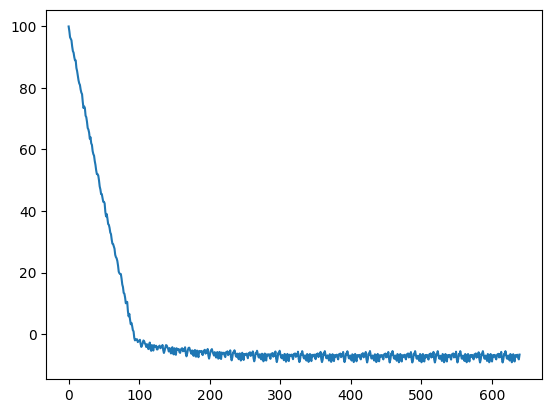

In [135]:
from matplotlib import pyplot as plt
plt.plot(losses)

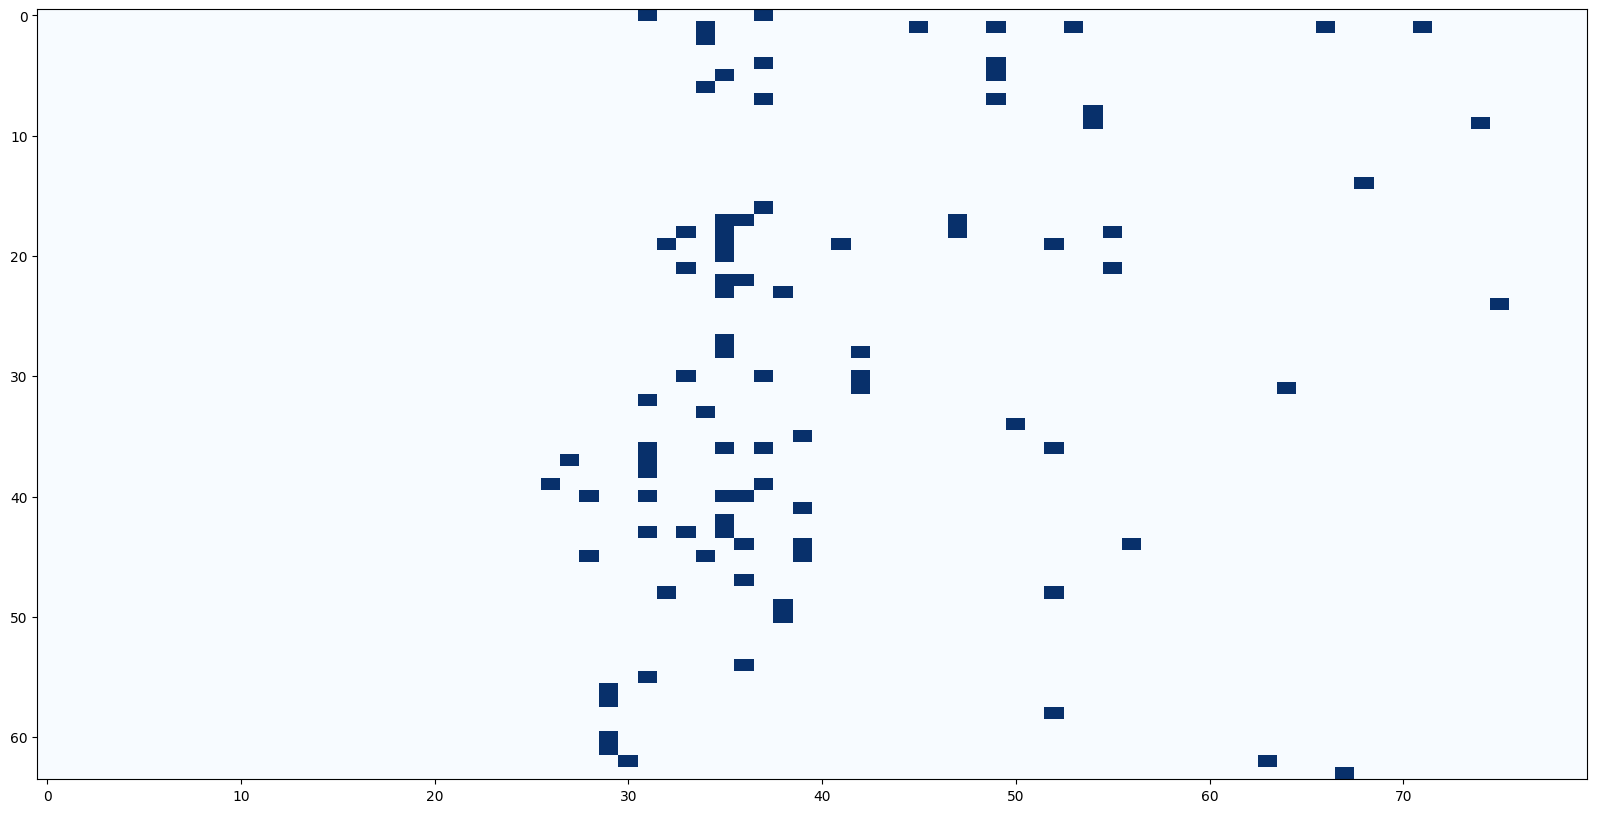

In [136]:
plt.figure(figsize=(20, 10))
plt.imshow(
    optimal_mask.round().T.to(torch.float32).numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

In [143]:
heads_selected = torch.nonzero(optimal_mask > 0.5, as_tuple=False).tolist()
len(heads_selected)

91

In [144]:
with open("optimized_heads.json", "w") as f:
    json.dump(heads_selected, f)

In [145]:
optimal_mask.sum()

tensor(91., dtype=torch.bfloat16)

## Validation of the patching effect

In [60]:
from src.functional import free_gpu_cache
free_gpu_cache()
validation_set = []
validation_limit = 200

while len(validation_set) < validation_limit:
    patch, clean = get_counterfactual_samples_within_task(
        filter_by_lm_prediction=True,
        prompt_template_idx=3,
        option_style="single_line",
        distinct_options=True,
    )
    validation_set.append((clean, patch))

2025-08-12 13:24:03 __main__ INFO     Patch category: animal, subject: Cat, object: Lion
2025-08-12 13:24:03 __main__ INFO     Clean category: vegetable, subject: Tomato, object: Mushroom
2025-08-12 13:24:03 __main__ INFO     patch_must_have_options=['Lion', 'Potato']
2025-08-12 13:24:03 __main__ INFO     clean_must_have_options=['Mushroom', 'Zebra']
2025-08-12 13:24:03 __main__ INFO     clean_type_obj='Potato'
2025-08-12 13:24:03 __main__ INFO     patch_type_obj='Zebra'
2025-08-12 13:24:03 __main__ INFO     patch_obj_idx=1 | ['Potato', 'Lion', 'Pen', 'Theater', 'Pear', 'Maple']
2025-08-12 13:24:03 __main__ INFO     clean_obj_idx=3 | ['Zebra', 'Flute', 'Train', 'Mushroom', 'Rose', 'Paper']
2025-08-12 13:24:03 __main__ INFO     Options: Potato, Lion, Pen, Theater, Pear, Maple.
Which among these objects mentioned above is a animal?
Answer:
2025-08-12 13:24:03 __main__ INFO     Cat | animal -> Lion | pred=['" Lion"[33199] (p=0.719, logit=21.250)', '" The"[578] (p=0.110, logit=19.375)', '"

In [146]:
print(clean_sample.prompt(), ">>", clean_sample.obj)

Options: Zebra, Bathtub, Yoga mat, Lettuce, Hat, Mango.
Which among these objects mentioned above is a fruit?
Answer: >> Mango


In [147]:
# mt.tokenizer.decode(clean_sample.obj_token_id)
mt.tokenizer.decode(clean_sample.metadata["track_type_obj_token_id"])

' Bat'

In [164]:
from typing import Optional

from src.functional import (
    get_module_nnsight,
    PatchSpec,
    interpret_logits,
    patch_with_baukit,
)
from src.selection.utils import get_first_token_id


@torch.inference_mode()
def validate_q_proj_ie_on_sample_pair(
    mt: ModelandTokenizer,
    clean_sample: SelectionSample,
    patch_sample: SelectionSample,
    heads: list[tuple[int, int]],
    query_indices: int = [-1],
    verify_head_behavior_on: Optional[int] = None,
):
    clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)
    patch_tokenized = prepare_input(prompts=patch_sample.prompt(), tokenizer=mt)

    if verify_head_behavior_on is not None:
        logger.info("Verifying head behavior...")

        logger.info(f"Clean Sample >> Ans: {clean_sample.obj}")
        clean_attn_pattern = verify_head_patterns(
            prompt=clean_tokenized,
            options=clean_sample.options,
            pivot=clean_sample.subj,
            mt=mt,
            heads=heads,
            generate_full_answer=True,
            query_index=verify_head_behavior_on,
        )

        logger.info(f"Patch Sample >> Ans: {patch_sample.obj}")
        patch_attn_pattern = verify_head_patterns(
            prompt=patch_tokenized,
            options=patch_sample.options,
            pivot=patch_sample.subj,
            mt=mt,
            heads=heads,
            generate_full_answer=True,
            query_index=verify_head_behavior_on,
        )

    logger.info(f"Caching the query states for the {len(heads)} heads")

    query_locations = [
        (layer_idx, head_idx, query_idx)
        for layer_idx, head_idx in heads
        for query_idx in query_indices
    ]

    cached_q_states, patch_output = cache_q_projections(
        mt=mt,
        input=patch_tokenized,
        query_locations=query_locations,
        return_output=True,
    )
    q_proj_patches = []
    for (layer_idx, head_idx, query_idx), q_proj in cached_q_states.items():
        q_proj_patches.append(
            PatchSpec(
                location=(
                    mt.attn_module_name_format.format(layer_idx) + ".q_proj",
                    head_idx,
                    query_idx,
                ),
                patch=q_proj,
            )
        )

    patch_logits = patch_output.logits[:, -1, :].squeeze()
    patch_predictions = interpret_logits(
        tokenizer=mt,
        logits=patch_logits,
    )
    logger.info(f"patch_prediction={[str(pred) for pred in patch_predictions]}")

    # interested_tokens = [
    #     patch_sample.ans_token_id,
    #     clean_sample.ans_token_id,
    #     clean_sample.metadata["track_type_obj_token_id"],
    # ]
    interested_tokens = clean_sample.options
    interested_tokens = [get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ") for opt in interested_tokens]
    interested_tokens += [patch_sample.ans_token_id]
    # interested_tokens = list(set(interested_tokens))  # remove duplicates #! don't need to, made sure during sampling

    logger.info("clean run")
    clean_output = patch_with_baukit(
        mt=mt,
        inputs=clean_tokenized,
        patches=[],
    )
    clean_logits = clean_output.logits[:, -1, :].squeeze()
    clean_predictions, clean_track = interpret_logits(
        tokenizer=mt,
        logits=clean_logits,
        interested_tokens=interested_tokens,
    )
    logger.info(f"clean_prediction={[str(pred) for pred in clean_predictions]}")
    logger.info(f"clean_track={clean_track}")

    logger.info("patching the q_proj states")
    if verify_head_behavior_on is not None:
        int_attn_pattern = verify_head_patterns(
            prompt=clean_tokenized,
            options=clean_sample.options,
            pivot=clean_sample.subj,
            mt=mt,
            heads=heads,
            query_patches=q_proj_patches,
            generate_full_answer=False,
            query_index=verify_head_behavior_on,
        )
        int_logits = int_attn_pattern["logits"].squeeze()

    else:
        int_out = patch_with_baukit(
            mt=mt,
            inputs=clean_tokenized,
            patches=q_proj_patches,
        )
        int_logits = int_out.logits[:, -1, :].squeeze()

    int_predictions, int_track = interpret_logits(
        tokenizer=mt,
        logits=int_logits,
        interested_tokens=interested_tokens,
    )
    logger.info(f"int_prediction={[str(pred) for pred in int_predictions]}")
    logger.info(f"int_track={int_track}")

    return {
        "clean_sample": clean_sample,
        "patch_sample": patch_sample,
        "clean_predictions": clean_predictions,
        "patch_predictions": patch_predictions,
        "int_predictions": int_predictions,
        "clean_track": clean_track,
        "int_track": int_track,
    }


# clean, patch = validation_set[25]
# clean, patch = clean_sample, patch_sample
failed_case = failed_cases[0]
clean = failed_case["clean_sample"]
patch = failed_case["patch_sample"]

print(clean.prompt(), ">>", clean.obj)
print(patch.prompt(), ">>", patch.obj)

validation_result = validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=clean,
    patch_sample=patch,
    # heads=HEADS,
    heads = heads_selected,
    query_indices=[-3, -2, -1],
    verify_head_behavior_on=-1,
)

Options: Pencil, Cherry, Temple, Bamboo, Cabinet, Dishwasher.
Which among these objects mentioned above is a fruit?
Answer: >> Cherry
Options: Pear, Smartwatch, Oak, Recliner, Juicer, Pin.
Which among these objects mentioned above is a kitchen appliance?
Answer: >> Juicer
2025-08-12 15:28:18 __main__ INFO     Verifying head behavior...
2025-08-12 15:28:18 __main__ INFO     Clean Sample >> Ans: Cherry


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-12 15:28:21 src.experiments.utils DEBUG    Generated full answer: " Cherry. Cherry is a fruit. The other options are not fruits. Pencil is a writing instrument, Temple is a place of worship, Bamboo is"
2025-08-12 15:28:21 src.experiments.utils DEBUG    Predictions: ['" Cherry"[45805] (p=0.934, logit=22.000)', '" The"[578] (p=0.022, logit=18.250)', '" Among"[22395] (p=0.012, logit=17.625)', '" P"[393] (p=0.005, logit=16.750)', '" ("[320] (p=0.003, logit=16.375)']
2025-08-12 15:28:21 src.experiments.utils INFO     Combined attention matrix for all heads


2025-08-12 15:28:21 __main__ INFO     Patch Sample >> Ans: Juicer


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-12 15:28:25 src.experiments.utils DEBUG    Generated full answer: " Juicer
Explanation: A juicer is a kitchen appliance used to extract juice from fruits and vegetables. The other options are not kitchen appliances. A"
2025-08-12 15:28:25 src.experiments.utils DEBUG    Predictions: ['" Ju"[22410] (p=0.453, logit=20.250)', '" The"[578] (p=0.167, logit=19.250)', '" Among"[22395] (p=0.147, logit=19.125)', '" A"[362] (p=0.114, logit=18.875)', '" Pear"[23910] (p=0.029, logit=17.500)']
2025-08-12 15:28:25 src.experiments.utils INFO     Combined attention matrix for all heads


2025-08-12 15:28:25 __main__ INFO     Caching the query states for the 91 heads
2025-08-12 15:28:25 __main__ INFO     patch_prediction=['" Ju"[22410] (p=0.453, logit=20.250)', '" The"[578] (p=0.167, logit=19.250)', '" Among"[22395] (p=0.146, logit=19.125)', '" A"[362] (p=0.114, logit=18.875)', '" Pear"[23910] (p=0.029, logit=17.500)']
2025-08-12 15:28:25 __main__ INFO     clean run
2025-08-12 15:28:26 __main__ INFO     clean_prediction=['" Cherry"[45805] (p=0.934, logit=22.000)', '" The"[578] (p=0.022, logit=18.250)', '" Among"[22395] (p=0.012, logit=17.625)', '" P"[393] (p=0.005, logit=16.750)', '" ("[320] (p=0.003, logit=16.375)']
2025-08-12 15:28:26 __main__ INFO     clean_track=OrderedDict([(45805, (1, PredictedToken(token=' Cherry', prob=0.93359375, logit=22.0, token_id=45805, metadata=None))), (393, (4, PredictedToken(token=' P', prob=0.0048828125, logit=16.75, token_id=393, metadata=None))), (19176, (52, PredictedToken(token=' Temple', prob=7.43865966796875e-05, logit=12.5625, t

2025-08-12 15:28:26 __main__ INFO     int_prediction=['" Cherry"[45805] (p=0.475, logit=20.625)', '" P"[393] (p=0.420, logit=20.500)', '" The"[578] (p=0.027, logit=17.750)', '" Among"[22395] (p=0.018, logit=17.375)', '" None"[2290] (p=0.008, logit=16.500)']
2025-08-12 15:28:26 __main__ INFO     int_track=OrderedDict([(45805, (1, PredictedToken(token=' Cherry', prob=0.474609375, logit=20.625, token_id=45805, metadata=None))), (393, (2, PredictedToken(token=' P', prob=0.419921875, logit=20.5, token_id=393, metadata=None))), (49268, (9, PredictedToken(token=' Dish', prob=0.0028228759765625, logit=15.5, token_id=49268, metadata=None))), (34046, (11, PredictedToken(token=' Cabinet', prob=0.002349853515625, logit=15.3125, token_id=34046, metadata=None))), (19176, (15, PredictedToken(token=' Temple', prob=0.0011749267578125, logit=14.625, token_id=19176, metadata=None))), (98028, (23, PredictedToken(token=' Bamboo', prob=0.00067138671875, logit=14.0625, token_id=98028, metadata=None))), (2241

In [153]:
from tqdm.auto import tqdm

validation_results = []
for clean_sample, patch_sample in tqdm(validation_set):
    result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        # heads=HEADS,
        heads = heads_selected,
        query_indices=[-3, -2, -1],
        verify_head_behavior_on=None,
    )
    validation_results.append(result)
    print("=" * 80)

  0%|          | 0/200 [00:00<?, ?it/s]

2025-08-12 15:19:45 __main__ INFO     Caching the query states for the 91 heads
2025-08-12 15:19:46 __main__ INFO     patch_prediction=['" Lion"[33199] (p=0.719, logit=21.250)', '" The"[578] (p=0.110, logit=19.375)', '" A"[362] (p=0.067, logit=18.875)', '" Among"[22395] (p=0.059, logit=18.750)', '" It"[1102] (p=0.004, logit=16.125)']
2025-08-12 15:19:46 __main__ INFO     clean run
2025-08-12 15:19:46 __main__ INFO     clean_prediction=['" Mushroom"[91297] (p=0.836, logit=20.750)', '" None"[2290] (p=0.037, logit=17.625)', '" The"[578] (p=0.029, logit=17.375)', '" A"[362] (p=0.020, logit=17.000)', '" There"[2684] (p=0.015, logit=16.750)']
2025-08-12 15:19:46 __main__ INFO     clean_track=OrderedDict([(91297, (1, PredictedToken(token=' Mushroom', prob=0.8359375, logit=20.75, token_id=91297, metadata=None))), (1901, (10, PredictedToken(token=' Z', prob=0.0028228759765625, logit=15.0625, token_id=1901, metadata=None))), (27217, (12, PredictedToken(token=' Train', prob=0.00182342529296875, l

In [154]:
before_intervention = []
after_intervention = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]

    clean_obj = clean_sample.ans_token_id
    target_obj = clean_sample.metadata["track_type_obj_token_id"]

    before_intervention.append({
        "clean_rank": intervention_result["clean_track"][clean_obj][0],
        "clean_logit": intervention_result["clean_track"][clean_obj][1].logit,
        "target_rank": intervention_result["clean_track"][target_obj][0],
        "target_logit": intervention_result["clean_track"][target_obj][1].logit,
    })

    after_intervention.append({
        "clean_rank": intervention_result["int_track"][clean_obj][0],
        "clean_logit": intervention_result["int_track"][clean_obj][1].logit,
        "target_rank": intervention_result["int_track"][target_obj][0],
        "target_logit": intervention_result["int_track"][target_obj][1].logit,
    })

In [155]:
import numpy as np

clean_rank_delta = [
    after["clean_rank"] - before["clean_rank"]
    for before, after in zip(before_intervention, after_intervention)
]
target_rank_delta = [
    after["target_rank"] - before["target_rank"]
    for before, after in zip(before_intervention, after_intervention)
]

clean_rank_delta, target_rank_delta = np.array(clean_rank_delta), np.array(
    target_rank_delta
)
print(f"clean_rank_delta: {clean_rank_delta.mean():.4f} ± {clean_rank_delta.std():.4f}")
print(
    f"target_rank_delta: {target_rank_delta.mean():.4f} ± {target_rank_delta.std():.4f}"
)

clean_rank_after_intervention = [after["clean_rank"] for after in after_intervention]
clean_rank_after_intervention = np.array(clean_rank_after_intervention)
print(
    f"clean_rank_after_intervention: {clean_rank_after_intervention.mean():.4f} ± {clean_rank_after_intervention.std():.4f}"
)

target_rank_after_intervention = [after["target_rank"] for after in after_intervention]
target_rank_after_intervention = np.array(target_rank_after_intervention)
print(
    f"target_rank_after_intervention: {target_rank_after_intervention.mean():.4f} ± {target_rank_after_intervention.std():.4f}"
)

clean_rank_delta: 439.6500 ± 1091.2597
target_rank_delta: -251.5850 ± 478.8970
clean_rank_after_intervention: 440.6550 ± 1091.2577
target_rank_after_intervention: 7.2400 ± 30.6289


In [156]:
clean_logit_delta = [
    after["clean_logit"] - before["clean_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
target_logit_delta = [
    after["target_logit"] - before["target_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
clean_logit_delta, target_logit_delta = np.array(clean_logit_delta), np.array(target_logit_delta)
print(f"clean_logit_delta: {clean_logit_delta.mean():.4f} ± {clean_logit_delta.std():.4f}")
print(f"target_logit_delta: {target_logit_delta.mean():.4f} ± {target_logit_delta.std():.4f}")

clean_logit_after_intervention = [
    after["clean_logit"]
    for after in after_intervention
]
clean_logit_after_intervention = np.array(clean_logit_after_intervention)
print(f"clean_logit_after_intervention: {clean_logit_after_intervention.mean():.4f} ± {clean_logit_after_intervention.std():.4f}")

target_logit_after_intervention = [
    after["target_logit"]
    for after in after_intervention
]
target_logit_after_intervention = np.array(target_logit_after_intervention)
print(f"target_logit_after_intervention: {target_logit_after_intervention.mean():.4f} ± {target_logit_after_intervention.std():.4f}")

clean_logit_delta: -10.3359 ± 3.5530
target_logit_delta: 8.6173 ± 3.9500
clean_logit_after_intervention: 11.1173 ± 3.4170
target_logit_after_intervention: 20.3412 ± 2.5619


In [157]:
top_1 = sum([1 for after in after_intervention if after["target_rank"] == 1])
top_1 / len(after_intervention)

0.76

In [159]:
counter_patch_type_top_option = 0
failed_cases = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["int_track"]
    clean_track = intervention_result["clean_track"]
    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == clean_sample.metadata["track_type_obj_token_id"]
    ): 
        counter_patch_type_top_option += 1
    else:
        failed_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
            }
        )

top_1_accuracy = counter_patch_type_top_option / len(validation_results)
print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f} ({counter_patch_type_top_option}/{len(validation_results)})"
)

Counterfactual patching accuracy: 0.7650 (153/200)


In [160]:
for failed_case in failed_cases[:20]:
    clean_sample = failed_case["clean_sample"]
    patch_sample = failed_case["patch_sample"]
    int_track = failed_case["int_track"]
    clean_track = failed_case["clean_track"]

    print("Clean Sample:")
    print(clean_sample.prompt(), ">>", clean_sample.obj)

    print("-" * 100)
    print(clean_sample.metadata["track_category"], ">>", clean_sample.metadata["track_type_obj"])
    print("-" * 100)

    clean_track = [pred for tok_id, (rank, pred) in clean_track.items()]
    print(f"Clean Track: {json.dumps([str(pred) for pred in clean_track], indent=4)}")

    int_track = [pred for tok_id, (rank, pred) in int_track.items()]
    print(f"Intervened Track: {json.dumps([str(pred) for pred in int_track], indent=4)}")
    print("=" * 100)


Clean Sample:
Options: Pencil, Cherry, Temple, Bamboo, Cabinet, Dishwasher.
Which among these objects mentioned above is a fruit?
Answer: >> Cherry
----------------------------------------------------------------------------------------------------
kitchen appliance >> Dishwasher
----------------------------------------------------------------------------------------------------
Clean Track: [
    "\" Cherry\"[45805] (p=0.934, logit=22.000)",
    "\" P\"[393] (p=0.005, logit=16.750)",
    "\" Temple\"[19176] (p=0.000, logit=12.562)",
    "\" Bamboo\"[98028] (p=0.000, logit=11.438)",
    "\" Dish\"[49268] (p=0.000, logit=10.125)",
    "\" Cabinet\"[34046] (p=0.000, logit=8.875)",
    "\" Ju\"[22410] (p=0.000, logit=7.250)"
]
Intervened Track: [
    "\" Cherry\"[45805] (p=0.475, logit=20.625)",
    "\" P\"[393] (p=0.420, logit=20.500)",
    "\" Dish\"[49268] (p=0.003, logit=15.500)",
    "\" Cabinet\"[34046] (p=0.002, logit=15.312)",
    "\" Temple\"[19176] (p=0.001, logit=14.625)",
    

In [102]:
mt.tokenizer.decode(failed_cases[0]["clean_sample"].metadata["track_type_obj_token_id"])

' Dish'

In [103]:
clean_sample.metadata.keys()

dict_keys(['track_category', 'track_type_obj', 'track_type_obj_idx', 'track_type_obj_token_id', 'tokenized'])